# Desafio Codenation: Descubra as melhores notas de matemática do ENEM 2016 - Continuação

## Introdução

Nesse notebook, vamos continuar a trabalhar no [desafio](https://www.codenation.dev/acceleration/aceleradev-data-science/challenge/enem-ps) de criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016, só que vamos menlhorar o modelo que começamos anteriormente.

Nossas melhorias nesse notebook incluem:

- Uso de mais features
- Mais feature engineering, principalmente com o uso de variáveis dummy no lugar de algumas features categóricas
- Uso de random search e grid search para tunar os hiperparâmetros do nosso modelo de LightGBM
- Uso de algumas técnicas para interpretar melhor nosso modelo (*permutation importance*, *partial dependence plots* e *SHAP values*)

## Notebook setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score

from lightgbm import LGBMRegressor

/anaconda3/envs/tera-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
plt.style.use('ggplot')

## Carregando os dados

In [4]:
data = pd.read_csv('train.csv', header=0)

In [5]:
data.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [6]:
data.shape

(13730, 167)

## Limpando os dados

No notebook anterior, usamos apenas algumas das features disponíveis no dataset. Olhando para o arquivo `test.csv`, que contém os dados que serão usados para avaliar o modelo, vemos que nele não constam todas as features que estão no arquivo `train.csv`.

Para melhorar nosso modelo, vamos incorporar mais das features disponíveis em `test.csv`. As features disponíveis que não incluímos no modelo anterior, mas que vamos incluir agora são:

- `SG_UF_RESIDENCIA`
- `TP_DEPENDENCIA_ADM_ESC`
- `IN_BAIXA_VISAO`
- `IN_SABATISTA`
- `TP_PRESENCA_CN`
- `TP_PRESENCA_CH`
- `CO_PROVA_MT`
- `TP_STATUS_REDACAO`
- `NU_NOTA_COMP1`
- `NU_NOTA_COMP2`
- `NU_NOTA_COMP3`
- `NU_NOTA_COMP4`
- `NU_NOTA_COMP5`
- `Q024`
- `Q025`
- `Q027`
- `Q047`

In [7]:
feat_cols = ['NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
             'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH',
             'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q026']

additional_feat_cols = ['SG_UF_RESIDENCIA', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_SABATISTA',
                        'TP_PRESENCA_CN', 'TP_PRESENCA_CH',
                        'CO_PROVA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
                        'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'Q024', 'Q025',
                        'Q027', 'Q047']

df = data[feat_cols + additional_feat_cols]

In [8]:
df.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,...,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,Q024,Q025,Q027,Q047
0,24,M,1,1,1,4,1,NaN,0,436.3,...,1.0,120.0,120.0,120.0,80.0,80.0,A,A,H,A
1,17,F,3,1,2,0,2,1.0,0,474.5,...,1.0,140.0,120.0,120.0,120.0,80.0,A,A,NaN,A
2,21,F,3,1,3,0,1,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,A,A,NaN,A
3,25,F,0,1,1,9,1,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,C,B,F,D
4,28,M,2,1,1,4,1,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,A,A,F,A


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 36 columns):
NU_IDADE                  13730 non-null int64
TP_SEXO                   13730 non-null object
TP_COR_RACA               13730 non-null int64
TP_NACIONALIDADE          13730 non-null int64
TP_ST_CONCLUSAO           13730 non-null int64
TP_ANO_CONCLUIU           13730 non-null int64
TP_ESCOLA                 13730 non-null int64
TP_ENSINO                 4282 non-null float64
IN_TREINEIRO              13730 non-null int64
NU_NOTA_CN                10341 non-null float64
NU_NOTA_CH                10341 non-null float64
NU_NOTA_LC                10133 non-null float64
NU_NOTA_MT                10133 non-null float64
TP_LINGUA                 13730 non-null int64
NU_NOTA_REDACAO           10133 non-null float64
Q001                      13730 non-null object
Q002                      13730 non-null object
Q006                      13730 non-null object
Q026                      1373

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_IDADE,13730.0,21.593809,7.043654,13.0,17.0,19.0,23.0,67.0
TP_COR_RACA,13730.0,2.185652,1.007285,0.0,1.0,3.0,3.0,5.0
TP_NACIONALIDADE,13730.0,1.048871,0.258895,0.0,1.0,1.0,1.0,4.0
TP_ST_CONCLUSAO,13730.0,1.782666,0.880734,1.0,1.0,2.0,2.0,4.0
TP_ANO_CONCLUIU,13730.0,2.146176,3.217328,0.0,0.0,0.0,3.0,10.0
TP_ESCOLA,13730.0,1.353532,0.558472,1.0,1.0,1.0,2.0,4.0
TP_ENSINO,4282.0,1.178888,0.565490,1.0,1.0,1.0,1.0,3.0
IN_TREINEIRO,13730.0,0.129862,0.336163,0.0,0.0,0.0,0.0,1.0
NU_NOTA_CN,10341.0,473.495155,71.093674,0.0,419.9,459.8,514.5,806.4
NU_NOTA_CH,10341.0,529.661087,73.726344,0.0,480.4,532.0,581.2,807.0


## EDA, lidando com nulos e feature engineering

As variáveis com o maior número de nulos são:

In [11]:
df.isna().mean().sort_values(ascending=False)

TP_DEPENDENCIA_ADM_ESC    0.688128
TP_ENSINO                 0.688128
Q027                      0.536999
NU_NOTA_REDACAO           0.261981
NU_NOTA_LC                0.261981
NU_NOTA_COMP5             0.261981
NU_NOTA_COMP4             0.261981
NU_NOTA_COMP3             0.261981
NU_NOTA_COMP2             0.261981
NU_NOTA_COMP1             0.261981
TP_STATUS_REDACAO         0.261981
NU_NOTA_MT                0.261981
NU_NOTA_CH                0.246832
NU_NOTA_CN                0.246832
IN_TREINEIRO              0.000000
Q047                      0.000000
TP_ESCOLA                 0.000000
TP_ANO_CONCLUIU           0.000000
TP_NACIONALIDADE          0.000000
TP_COR_RACA               0.000000
TP_SEXO                   0.000000
TP_ST_CONCLUSAO           0.000000
Q006                      0.000000
TP_LINGUA                 0.000000
Q001                      0.000000
Q002                      0.000000
Q026                      0.000000
SG_UF_RESIDENCIA          0.000000
IN_BAIXA_VISAO      

### Features do modelo original

#### TP_ENSINO

Corresonde ao tipo de instituição que concluiu ou concluirá o Ensino Médio, onde:

- `1`: ensino regular
- `2`: educação especial - modalidade substitutiva
- `3`: educação de jovens e adultos

Quase 70% das observações nessa variável são nulas, mas acho que isso ainda pode ser uma feature interessante, então vou optar por manter esta variável e imputar os nulos com -1.

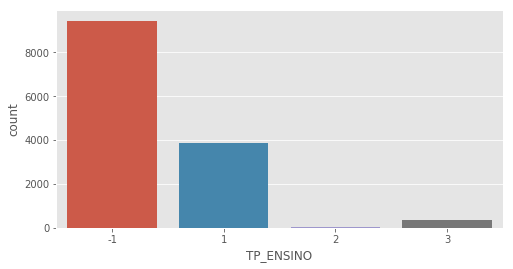

<Figure size 432x288 with 0 Axes>

In [12]:
df['TP_ENSINO'] = df['TP_ENSINO'].fillna(-1)
df['TP_ENSINO'] = df['TP_ENSINO'].astype('int')

ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ENSINO', data=df)
plt.show()
plt.clf()

In [13]:
df.groupby('TP_ENSINO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ENSINO,,,,,,,,
-1,6494.0,483.919587,99.941466,0.0,409.90,462.75,540.575,935.1
1,3386.0,482.282398,100.961588,0.0,408.90,460.00,535.975,952.0
2,23.0,464.982609,85.814984,376.4,384.45,447.20,522.950,691.9
3,230.0,447.282174,70.637989,335.4,394.00,429.55,490.900,712.3


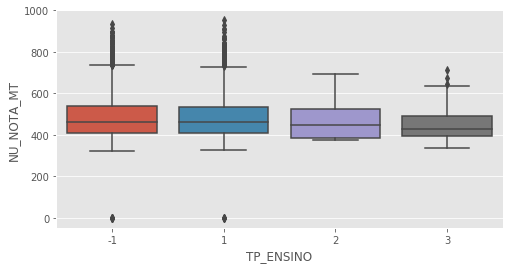

<Figure size 432x288 with 0 Axes>

In [14]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ENSINO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### NU_NOTA_X

Corresponde à nota em cada umas das provas.

Cerca de 1/4 das observações em cada uma dessas variáveis estão nulas e, pelo que podemos observar abaixo, na maioria dos casos, observações com nulos em uma dessas variáveis também terão nulos nas outras variáveis correspondentes.

In [15]:
NU_NOTA_X = ['NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']

In [16]:
df[NU_NOTA_X].head(n=20)

,NU_NOTA_REDACAO,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN
0,520.0,399.4,581.2,495.4,436.3
1,580.0,459.8,599.0,544.1,474.5
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,620.0,364.5,410.9,583.2,439.7
6,560.0,529.2,484.5,604.2,420.1
7,620.0,566.7,611.2,625.8,619.6
8,680.0,372.4,521.8,555.2,500.5
9,NaN,NaN,NaN,NaN,NaN


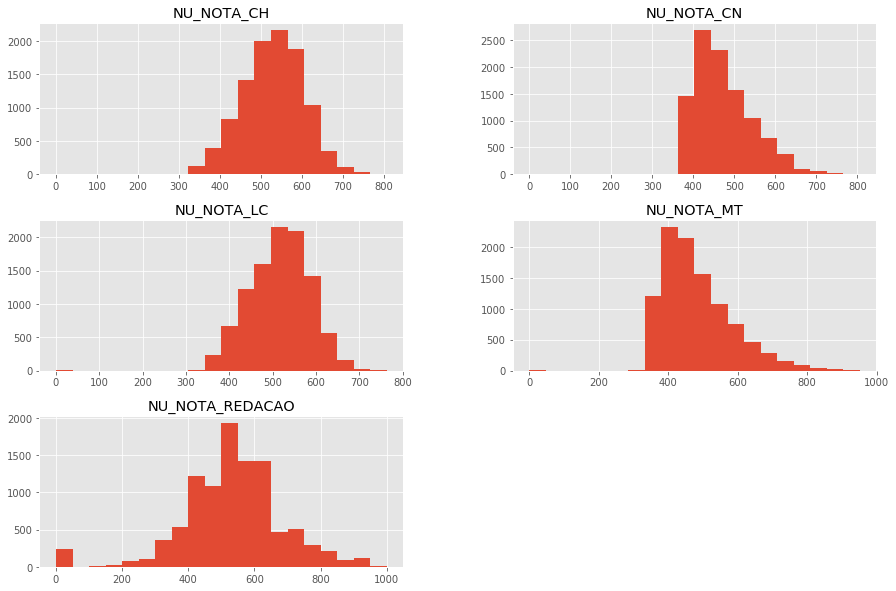

<Figure size 432x288 with 0 Axes>

In [17]:
df[NU_NOTA_X].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

Eu não sei ao certo, mas eu suspeito que os nulos nessas variáveis correspondem aos indivíduos que não entregaram a prova. Sendo assim, eu imputarei nota zero aos nulos.

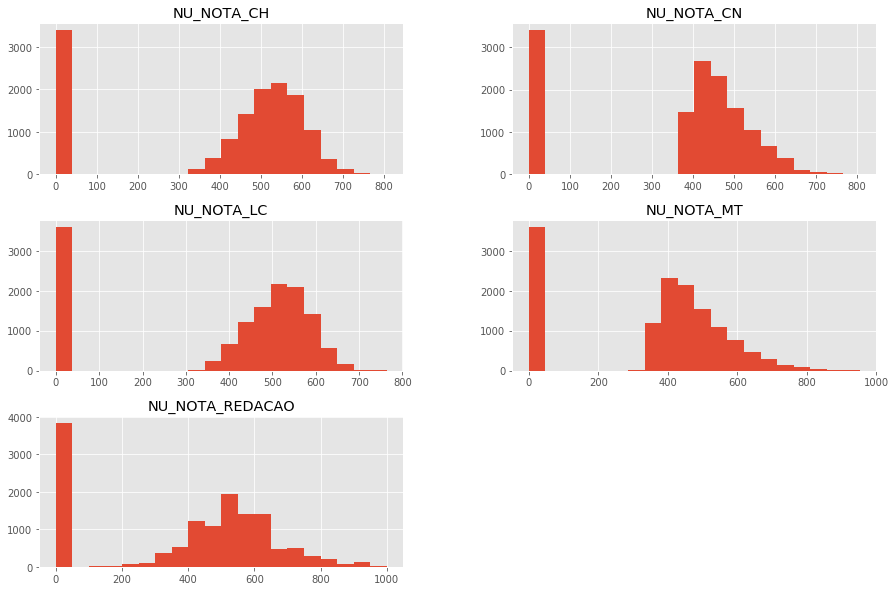

<Figure size 432x288 with 0 Axes>

In [18]:
df[NU_NOTA_X] = df[NU_NOTA_X].fillna(0.0)

df[NU_NOTA_X].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

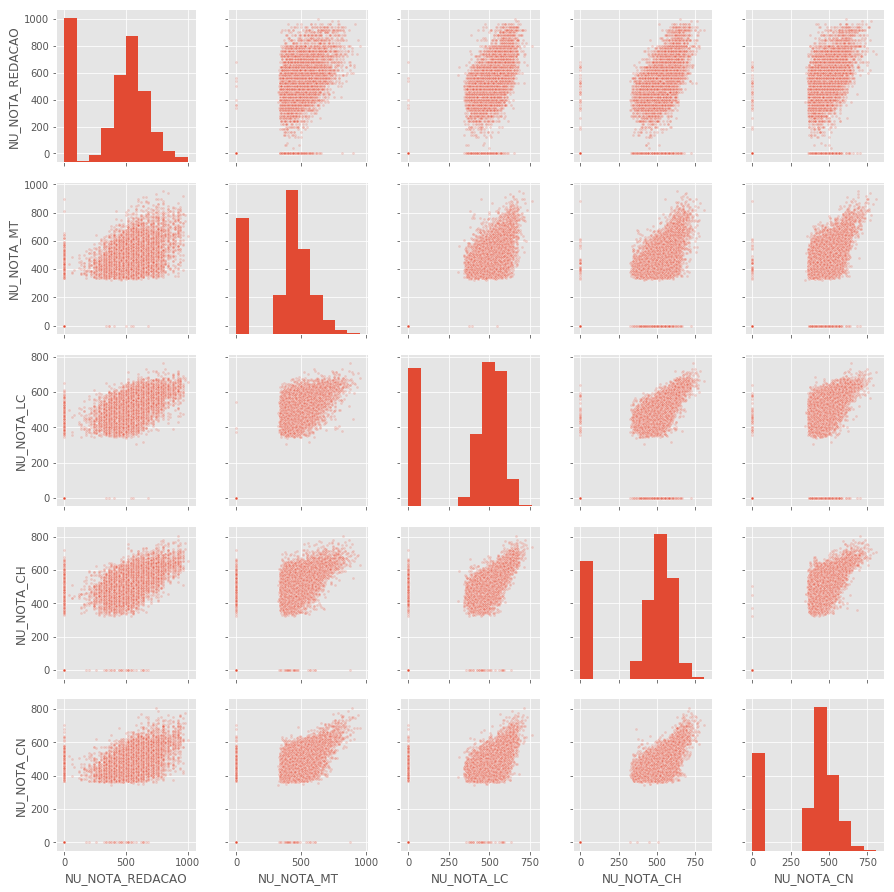

<Figure size 432x288 with 0 Axes>

In [19]:
sns.pairplot(df[NU_NOTA_X], plot_kws={'alpha': 0.2, 'marker': '.'})
plt.show()
plt.clf()

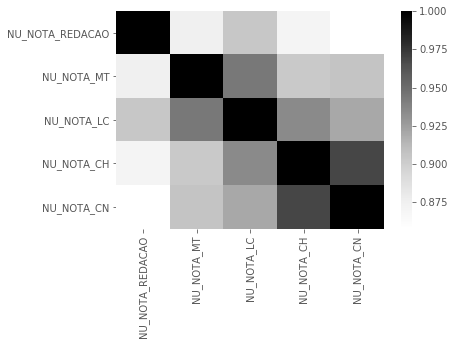

<Figure size 432x288 with 0 Axes>

In [20]:
corr_notas = df[NU_NOTA_X].corr()

sns.heatmap(corr_notas, cmap='Greys')
plt.show()
plt.clf()

Como era de se esperar, a correlação entre as notas que um indivíduo obteve em cada uma das provas é bem alta (ou seja, se ele foi bem em uma das provas, ele provavelmente também foi bem nas outras provas), sendo que a prova com a maior correlação com sua nota em matemática é a de linguagens e códigos.

#### Q026 - Trabalha?

Corresponde à pergunta "Você exerce ou já exerceu atividade remunerada?" do questionário socioeconômico, onde:

- `A`: não, nunca trabalhei
- `B`: sim, já trabalhei, mas não estou trabalhando
- `C`: sim, estou trabalhando

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: não, nunca trabalhei
- `1`: sim, já trabalhei, mas não estou trabalhando
- `2`: sim, estou trabalhando

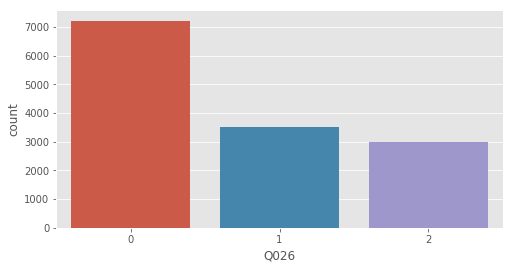

<Figure size 432x288 with 0 Axes>

In [21]:
le = LabelEncoder()

df['Q026'] = le.fit_transform(df['Q026'])

ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='Q026', data=df)
plt.show()
plt.clf()

In [22]:
df.groupby('Q026').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q026,,,,,,,,
0,7215.0,403.291365,203.460212,0.0,374.9,437.4,519.15,952.0
1,3509.0,302.669023,244.968485,0.0,0.0,403.7,489.30,895.5
2,3006.0,305.169228,241.979716,0.0,0.0,403.4,487.40,878.3


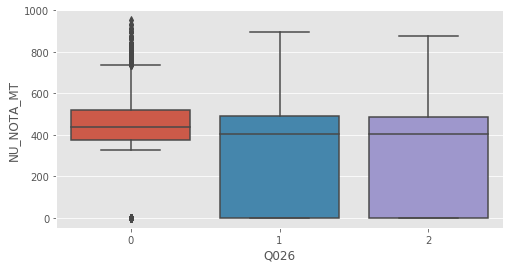

<Figure size 432x288 with 0 Axes>

In [23]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='Q026', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_ANO_CONCLUIU

Corresponde ao ano de conclusão do Ensino Médio, onde:

- `0`: não informado
- `1`: 2015
- ...
- `9`: 2007
- `10`: anterior a 2007

Vemos que os nulos estão na catergoria `0` e, conforme o gráfico abaixo, correspondem à marioria das observações. Assumo que isso seja porque a maioria dos indivíduos fazendo a prova ainda não concluiu o Ensino Médio.

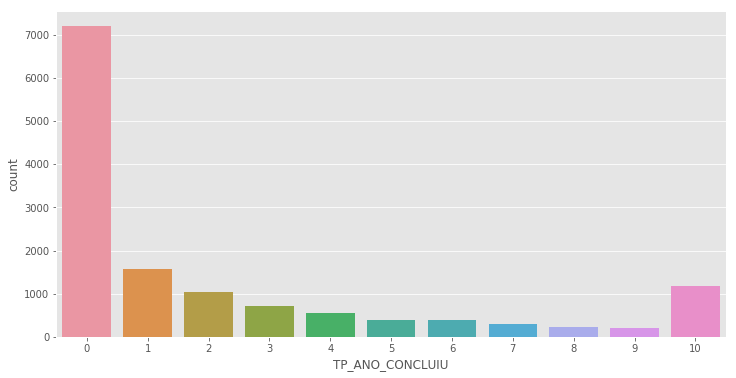

<Figure size 432x288 with 0 Axes>

In [24]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.countplot(x='TP_ANO_CONCLUIU', data=df)
plt.show()
plt.clf()

In [25]:
df.groupby('TP_ANO_CONCLUIU').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ANO_CONCLUIU,,,,,,,,
0,7206.0,382.063322,207.897328,0.0,365.300,429.60,506.000,952.0
1,1578.0,391.581749,225.457790,0.0,359.325,438.75,536.175,916.6
2,1033.0,368.063698,232.998690,0.0,0.000,428.60,521.000,935.1
3,712.0,347.186657,243.264350,0.0,0.000,425.75,508.750,896.3
4,563.0,314.306750,251.336858,0.0,0.000,416.20,490.000,800.1
5,379.0,294.606860,249.550994,0.0,0.000,397.60,488.550,897.0
6,383.0,270.873629,246.837446,0.0,0.000,376.30,484.550,788.2
7,294.0,292.084354,252.487986,0.0,0.000,387.30,488.775,843.9
8,221.0,280.998190,258.348113,0.0,0.000,392.60,492.400,854.7


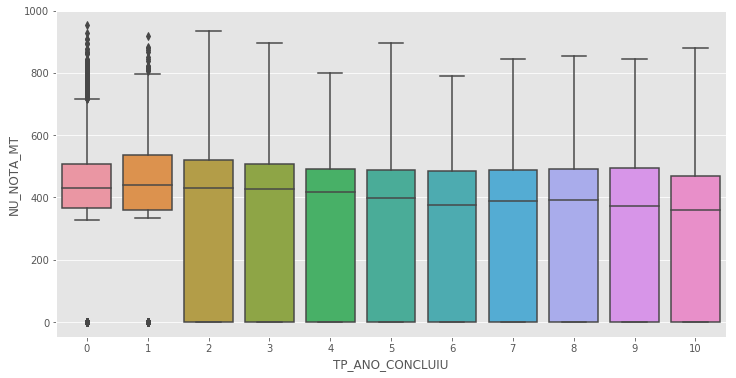

<Figure size 432x288 with 0 Axes>

In [26]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.boxplot(x='TP_ANO_CONCLUIU', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_SEXO

Corresponde ao sexo, onde:

- `M`: masculino
- `F`: feminino

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `1`: masculino
- `0`: feminino

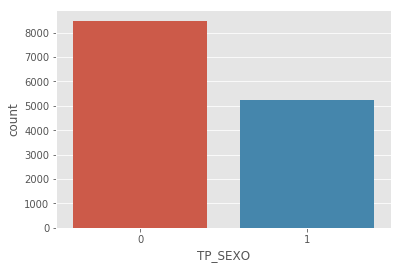

<Figure size 432x288 with 0 Axes>

In [27]:
le = LabelEncoder()

df['TP_SEXO'] = le.fit_transform(df['TP_SEXO'])

ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_SEXO', data=df)
plt.show()
plt.clf()

In [28]:
df.groupby('TP_SEXO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_SEXO,,,,,,,,
0,8491.0,345.115723,220.250907,0.0,0.0,415.0,487.90,935.1
1,5239.0,373.883165,241.087030,0.0,0.0,440.4,537.55,952.0


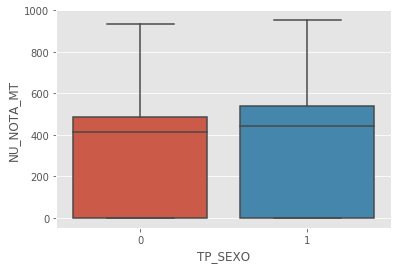

<Figure size 432x288 with 0 Axes>

In [29]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_SEXO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_COR_RACA

Corresponde à cor/raça declarada, onde:

- `0`: não declarado
- `1`: branca
- `2`: preta
- `3`: parda
- `4`: amarela
- `5`: indígena
- `6`: não dispõe da informação

Apesar de a descrição dos dados permitir nulos (categoria `6`), vemos abaixo que não há nenhuma observação nessa categoria.

Depois de feitos alguns gráficos vou trasformar essas variáveis em dummies, dropando a última coluna, `TP_COR_RACA_5`.

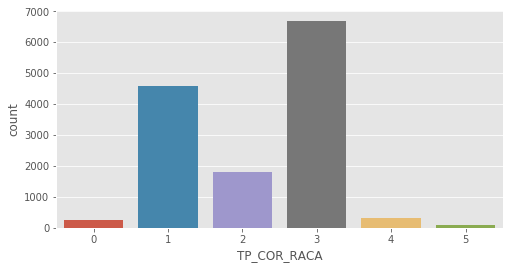

<Figure size 432x288 with 0 Axes>

In [30]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_COR_RACA', data=df)
plt.show()
plt.clf()

In [31]:
df.groupby('TP_COR_RACA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
0,241.0,344.212448,246.020475,0.0,0.0,409.9,497.70,857.9
1,4589.0,383.315581,238.776759,0.0,341.9,442.5,542.30,952.0
2,1794.0,338.196042,221.555351,0.0,0.0,416.7,485.05,916.6
3,6693.0,343.581100,221.025909,0.0,0.0,415.3,487.70,909.5
4,312.0,358.315385,235.290804,0.0,0.0,425.5,502.45,928.5
5,101.0,287.670297,227.877316,0.0,0.0,396.4,453.10,712.6


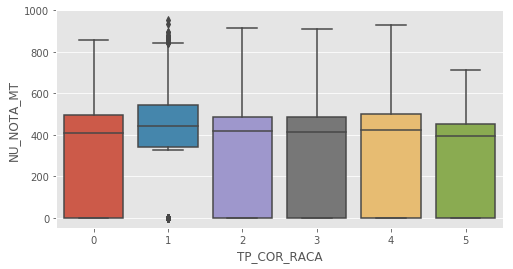

<Figure size 432x288 with 0 Axes>

In [32]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_COR_RACA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

Transformando as variáveis em dummies:

In [33]:
dummies_TP_COR_RACA = pd.get_dummies(df['TP_COR_RACA'], prefix='TP_COR_RACA')
dummies_TP_COR_RACA.drop('TP_COR_RACA_5', axis=1, inplace=True)

E juntando as novas dummy features ao DataFrame original:

In [34]:
df.drop('TP_COR_RACA', axis=1, inplace=True)
df = df.join(dummies_TP_COR_RACA)

#### TP_NACIONALIDADE

Corresponde à nacionalidade, onde:

- `0`: não informado
- `1`: brasileiro
- `2`: brasileiro naturalizado
- `3`: estrangeiro
- `4`: brasileiro nato, nascido no exterior

Vemos que os nulos estão na catergoria 0 mas, conforme vemos abaixo, estes correspondem à uma fração muito pequena das observações.

Depois de feitos alguns gráficos vou trasformar essas variáveis em dummies, dropando a coluna `TP_NACIONALIDADE_0`.

In [35]:
df['TP_NACIONALIDADE'].value_counts(dropna=False)

1    13121
2      548
4       40
0       13
3        8
Name: TP_NACIONALIDADE, dtype: int64

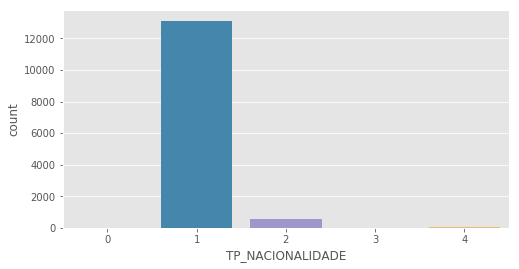

<Figure size 432x288 with 0 Axes>

In [36]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_NACIONALIDADE', data=df)
plt.show()
plt.clf()

In [37]:
df.groupby('TP_NACIONALIDADE').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_NACIONALIDADE,,,,,,,,
0,13.0,344.607692,199.476972,0.0,389.700,431.80,466.600,521.7
1,13121.0,358.346277,228.816862,0.0,0.000,423.60,506.800,952.0
2,548.0,299.677007,222.455767,0.0,0.000,400.15,459.375,724.9
3,8.0,439.287500,319.478340,0.0,283.050,433.45,682.500,840.8
4,40.0,376.820000,221.364350,0.0,362.325,428.05,519.300,752.5


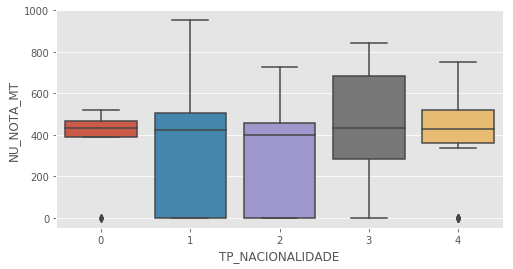

<Figure size 432x288 with 0 Axes>

In [38]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_NACIONALIDADE', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

Transformando as variáveis em dummies:

In [39]:
dummies_TP_NACIONALIDADE = pd.get_dummies(df['TP_NACIONALIDADE'], prefix='TP_NACIONALIDADE')
dummies_TP_NACIONALIDADE.drop('TP_NACIONALIDADE_0', axis=1, inplace=True)

E juntando as novas dummy features ao DataFrame original:

In [40]:
df.drop('TP_NACIONALIDADE', axis=1, inplace=True)
df = df.join(dummies_TP_NACIONALIDADE)

#### TP_ST_CONCLUSAO

Corresponde à situação de conclusão do Ensino Médio, onde:

- `1`: já concluiu
- `2`: cursando e concluirá em 2016
- `3`: cursando e concluirá após 2016
- `4`: não concluiu e não está cursando

Não há valores nulos.

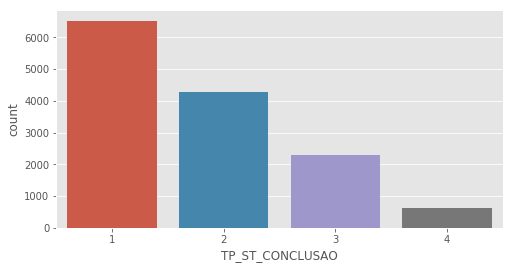

<Figure size 432x288 with 0 Axes>

In [41]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ST_CONCLUSAO', data=df)
plt.show()
plt.clf()

In [42]:
df.groupby('TP_ST_CONCLUSAO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ST_CONCLUSAO,,,,,,,,
1,6524.0,327.406990,246.808545,0.0,0.0,413.7,503.50,935.1
2,4283.0,407.876955,194.482847,0.0,379.7,439.9,516.50,952.0
3,2306.0,378.716088,203.557987,0.0,365.3,427.9,499.85,895.4
4,617.0,215.384117,234.652286,0.0,0.0,0.0,443.30,681.8


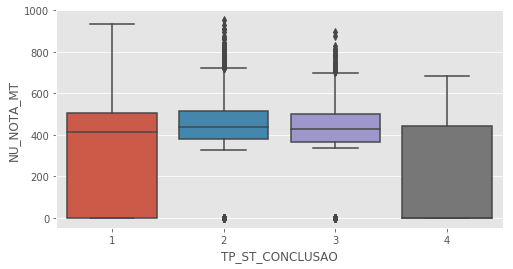

<Figure size 432x288 with 0 Axes>

In [43]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ST_CONCLUSAO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### IN_TREINEIRO

Corresponde a se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos, onde:

- `0`: não
- `1`: sim

Não há valores nulos.

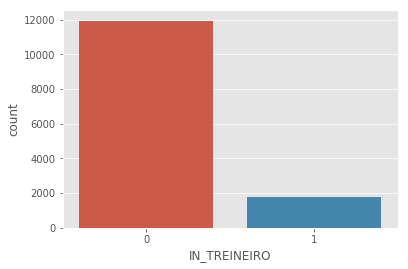

<Figure size 432x288 with 0 Axes>

In [44]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='IN_TREINEIRO', data=df)
plt.show()
plt.clf()

In [45]:
df.groupby('IN_TREINEIRO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
IN_TREINEIRO,,,,,,,,
0,11947.0,349.126048,232.900794,0.0,0.0,420.1,503.2,952.0
1,1783.0,402.772070,193.226999,0.0,377.2,438.6,513.5,895.4


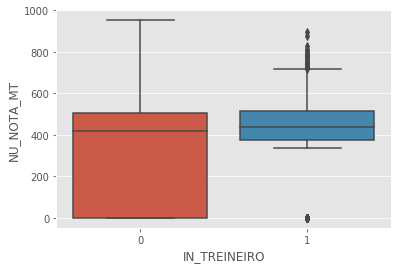

<Figure size 432x288 with 0 Axes>

In [46]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='IN_TREINEIRO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_ESCOLA

Corresponde ao tipo de escola do Ensino Médio, onde:

- `1`: não respondeu
- `2`: pública
- `3`: privada
- `4`: exterior

Vemos que os nulos estão na catergoria `1` e, conforme vemos abaixo, correspondem à maioria das observações.

Depois de feitos alguns gráficos vou trasformar essas variáveis em dummies, dropando a coluna `TP_ESCOLA_4`.

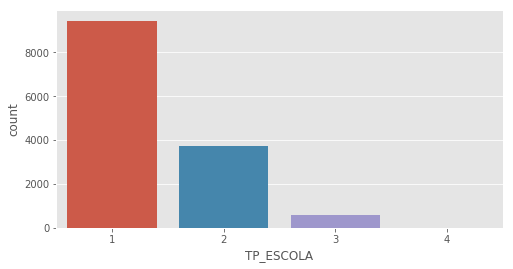

<Figure size 432x288 with 0 Axes>

In [47]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ESCOLA', data=df)
plt.show()
plt.clf()

In [48]:
df.groupby('TP_ESCOLA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ESCOLA,,,,,,,,
1,9447.0,332.615063,239.169388,0.0,0.0,414.5,498.65,935.1
2,3713.0,386.208161,187.878882,0.0,373.2,427.9,494.90,877.4
3,569.0,549.361687,177.008949,0.0,454.6,564.1,665.10,952.0
4,1.0,359.300000,NaN,359.3,359.3,359.3,359.30,359.3


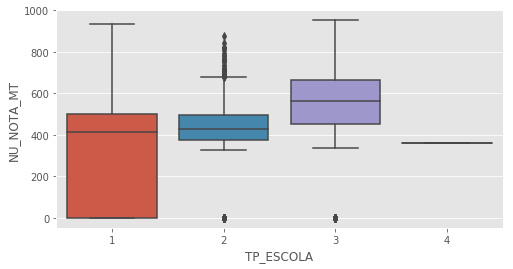

<Figure size 432x288 with 0 Axes>

In [49]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ESCOLA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

Transformando as variáveis em dummies:

In [50]:
dummies_TP_ESCOLA = pd.get_dummies(df['TP_ESCOLA'], prefix='TP_ESCOLA')
dummies_TP_ESCOLA.drop('TP_ESCOLA_4', axis=1, inplace=True)

E juntando as novas dummy features ao DataFrame original:

In [51]:
df.drop('TP_ESCOLA', axis=1, inplace=True)
df = df.join(dummies_TP_ESCOLA)

#### Q006 - Renda mensal

Corresponde à pergunta "Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)" do questionário socioeconômico, onde:
 
 - `A`: nenhuma renda
 - `B`: até R\$ 880
 - ...
 - `Q`: mais de R$ 17.600,00
 
Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

 - `0`: nenhuma renda
 - `1`: até R\$ 880
 - ...
 - `16`: mais de R$ 17.600,00

In [52]:
le = LabelEncoder()

df['Q006'] = le.fit_transform(df['Q006'])

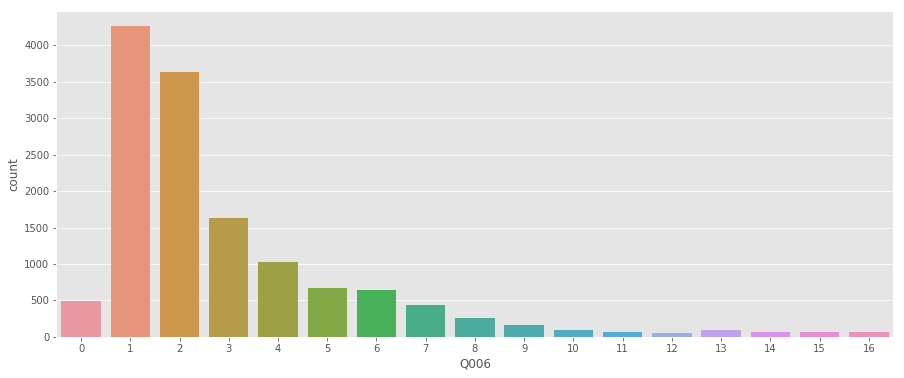

<Figure size 432x288 with 0 Axes>

In [53]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.countplot(x='Q006', data=df)
plt.show()
plt.clf()

In [54]:
df.groupby('Q006').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q006,,,,,,,,
0,491.0,301.232587,220.822728,0.0,0.000,392.10,451.900,840.9
1,4264.0,332.438039,207.209400,0.0,0.000,407.20,468.500,800.2
2,3641.0,329.317715,226.158232,0.0,0.000,413.80,486.600,896.3
3,1636.0,344.026284,232.372639,0.0,0.000,426.00,506.400,895.5
4,1028.0,367.003502,231.437298,0.0,0.000,427.00,523.300,952.0
5,667.0,383.779910,239.669104,0.0,335.350,442.70,549.550,874.1
6,642.0,402.330530,237.088261,0.0,371.175,469.45,552.850,829.1
7,433.0,457.927483,224.677898,0.0,407.700,507.20,600.700,877.6
8,253.0,484.933597,218.121805,0.0,423.800,518.40,636.400,895.4


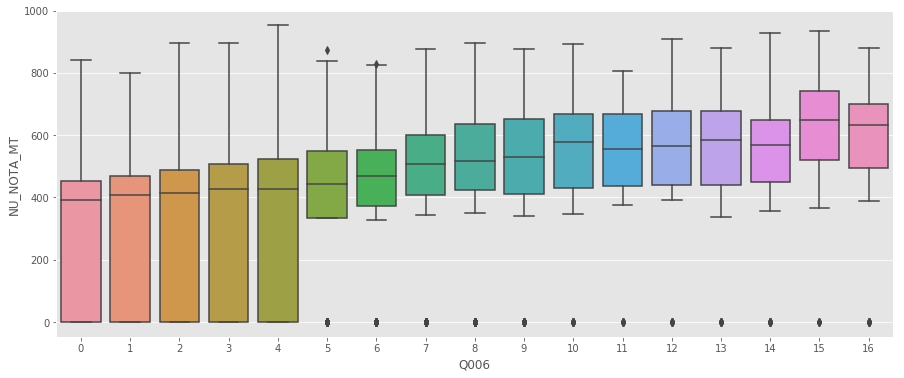

<Figure size 432x288 with 0 Axes>

In [55]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.boxplot(x='Q006', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_LINGUA

Corresponde à língua estrangeira escolhida pelo aluno no ENEM, onde:

- `0`: inglês
- `1`: espanhol

Não há nulos.

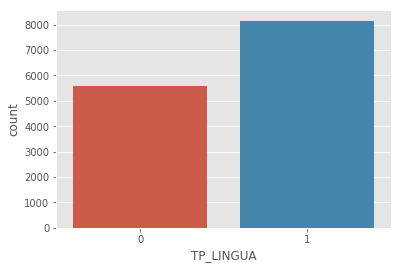

<Figure size 432x288 with 0 Axes>

In [56]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_LINGUA', data=df)
plt.show()
plt.clf()

In [57]:
df.groupby('TP_LINGUA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_LINGUA,,,,,,,,
0,5579.0,386.913587,235.959216,0.0,349.95,444.5,540.05,952.0
1,8151.0,334.997007,221.398549,0.0,0.00,411.6,483.90,840.9


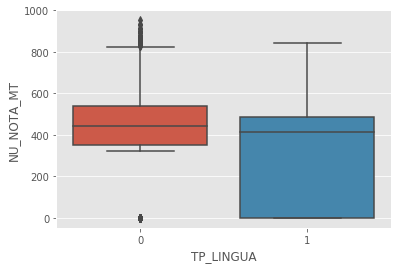

<Figure size 432x288 with 0 Axes>

In [58]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_LINGUA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### Q001 - Escolaridade do pai

Corresponde à pergunta "Até que série seu pai, ou o homem responsável por você, estudou?" do questionário socioeconômico, onde:

- `A`: nunca estudou
- `B`: não completou a 4ª série/5º ano do Ensino Fundamental
- `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `E`: completou o Ensino Médio, mas não completou a Faculdade
- `F`: completou a Faculdade, mas não completou a Pós-graduação
- `G`: completou a Pós-graduação
- `H`: não sei

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `-1`: não sei
- `0`: nunca estudou
- `1`: não completou a 4ª série/5º ano do Ensino Fundamental
- `2`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `3`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `4`: completou o Ensino Médio, mas não completou a Faculdade
- `5`: completou a Faculdade, mas não completou a Pós-graduação
- `6`: completou a Pós-graduação

In [59]:
le = LabelEncoder()
df['Q001'] = le.fit_transform(df['Q001'])

df['Q001'] = df['Q001'].apply(lambda x: -1 if x == 7 else x)

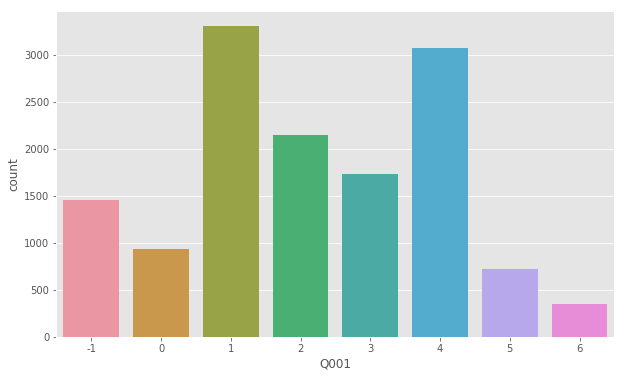

<Figure size 432x288 with 0 Axes>

In [60]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.countplot(x='Q001', data=df)
plt.show()
plt.clf()

In [61]:
df.groupby('Q001').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q001,,,,,,,,
-1,1456.0,335.114973,220.182430,0.0,0.000,408.60,481.125,897.0
0,934.0,290.369165,219.922946,0.0,0.000,393.30,452.375,701.4
1,3309.0,317.184467,221.120509,0.0,0.000,403.80,470.400,819.8
2,2146.0,350.173206,221.297752,0.0,0.000,419.35,496.575,895.5
3,1733.0,352.419388,226.311109,0.0,0.000,422.90,499.700,862.5
4,3079.0,392.880286,226.145958,0.0,364.550,447.70,537.200,916.6
5,719.0,470.869680,232.302155,0.0,410.850,520.10,622.400,935.1
6,354.0,480.247740,254.046839,0.0,408.725,534.65,666.150,952.0


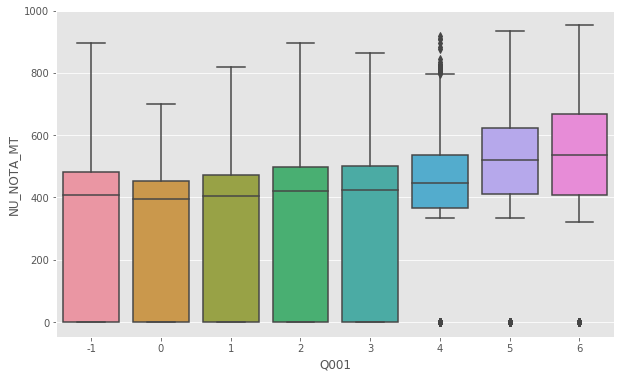

<Figure size 432x288 with 0 Axes>

In [62]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.boxplot(x='Q001', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### Q002 - Escolaridade da mãe

Corresponde à pergunta "Até que série sua mãe, ou a mulher responsável por você, estudou?" do questionário socioeconômico, onde:

- `A`: nunca estudou
- `B`: não completou a 4ª série/5º ano do Ensino Fundamental
- `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `E`: completou o Ensino Médio, mas não completou a Faculdade
- `F`: completou a Faculdade, mas não completou a Pós-graduação
- `G`: completou a Pós-graduação
- `H`: não sei

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `-1`: não sei
- `0`: nunca estudou
- `1`: não completou a 4ª série/5º ano do Ensino Fundamental
- `2`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `3`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `4`: completou o Ensino Médio, mas não completou a Faculdade
- `5`: completou a Faculdade, mas não completou a Pós-graduação
- `6`: completou a Pós-graduação

In [63]:
le = LabelEncoder()
df['Q002'] = le.fit_transform(df['Q002'])

df['Q002'] = df['Q002'].apply(lambda x: -1 if x == 7 else x)

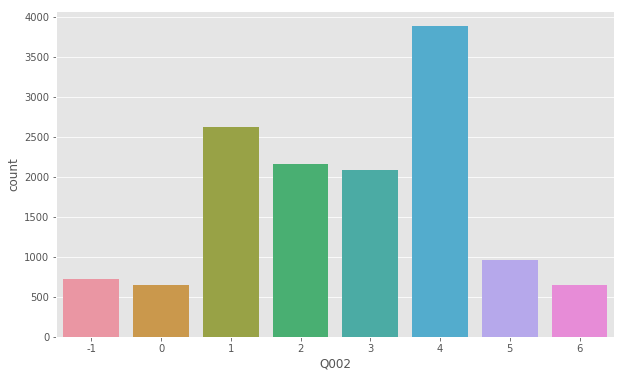

<Figure size 432x288 with 0 Axes>

In [64]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.countplot(x='Q002', data=df)
plt.show()
plt.clf()

In [65]:
df.groupby('Q002').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q002,,,,,,,,
-1,720.0,324.411389,219.280332,0.0,0.000,404.65,467.85,897.0
0,643.0,265.117885,223.424458,0.0,0.000,375.30,441.75,794.4
1,2627.0,306.881804,220.892372,0.0,0.000,398.80,463.70,851.0
2,2162.0,334.646300,221.715825,0.0,0.000,413.60,483.40,895.5
3,2083.0,342.634229,225.138757,0.0,0.000,417.30,493.90,908.8
4,3883.0,381.378161,224.509905,0.0,356.250,442.10,525.90,935.1
5,964.0,469.963382,221.931991,0.0,415.575,499.60,614.70,952.0
6,648.0,474.965278,220.476586,0.0,404.850,503.55,630.85,868.2


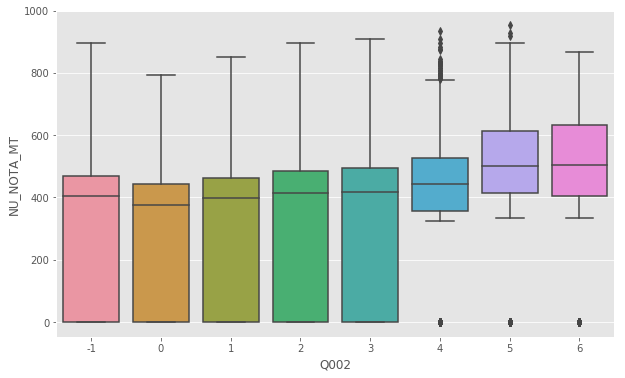

<Figure size 432x288 with 0 Axes>

In [66]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.boxplot(x='Q002', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### NU_IDADE

Corresponde à idade do inscrito. Não há nulos.

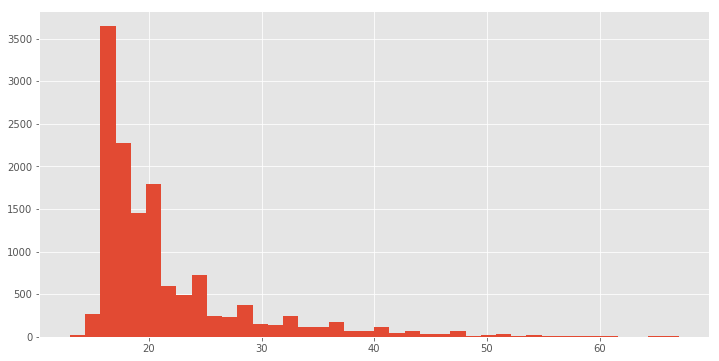

<Figure size 432x288 with 0 Axes>

In [67]:
df['NU_IDADE'].hist(bins=40, figsize=(12, 6))
plt.show()
plt.clf()

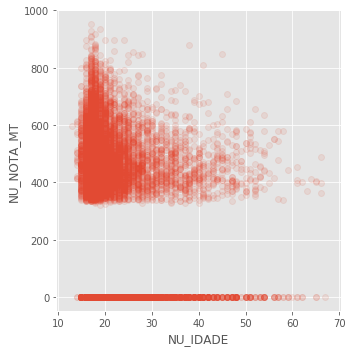

<Figure size 432x288 with 0 Axes>

In [68]:
sns.lmplot(x='NU_IDADE', y='NU_NOTA_MT', data=df,
           fit_reg=False, scatter_kws={'alpha':0.1})
plt.show()
plt.clf()

### Features novas

#### SG_UF_RESIDENCIA

Corresponde à sigla da Unidade da Federação de residência.

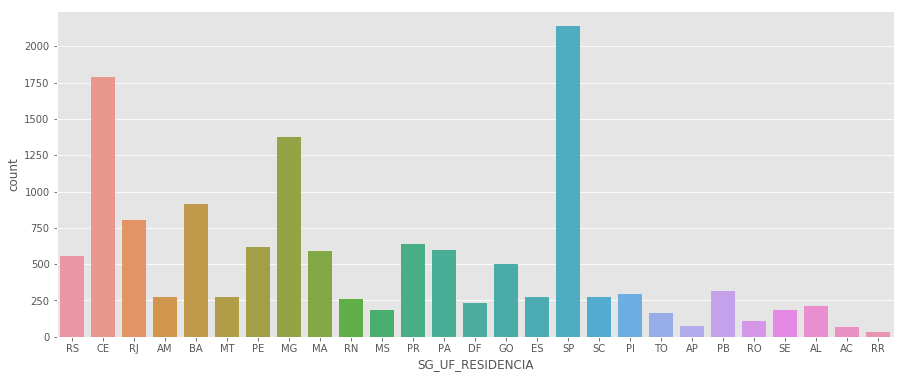

<Figure size 432x288 with 0 Axes>

In [69]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.countplot(x='SG_UF_RESIDENCIA', data=df)
plt.show()
plt.clf()

In [70]:
sg_uf_res_desc = df.groupby('SG_UF_RESIDENCIA').describe()['NU_NOTA_MT'].sort_values('mean', ascending=False)
sg_uf_res_desc

,count,mean,std,min,25%,50%,75%,max
SG_UF_RESIDENCIA,,,,,,,,
SE,183.0,400.317486,200.052483,0.0,382.050,433.20,500.400,800.2
SC,273.0,378.532967,227.831996,0.0,349.300,427.70,542.400,806.5
PB,316.0,373.248418,209.358897,0.0,367.100,424.50,502.825,854.7
ES,272.0,373.038235,217.256977,0.0,353.775,431.45,508.325,787.1
MG,1374.0,372.647889,242.376442,0.0,0.000,441.10,538.750,857.9
AL,210.0,368.122381,198.038631,0.0,363.900,420.45,491.050,713.3
TO,167.0,367.189222,207.360968,0.0,358.000,410.30,500.200,750.5
PI,292.0,364.963014,199.360598,0.0,358.050,416.15,476.550,803.5
PA,594.0,363.490404,208.383211,0.0,352.000,425.45,493.275,817.0


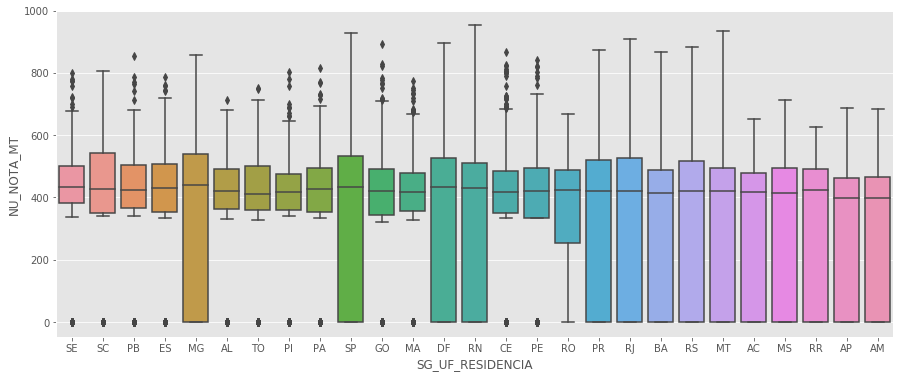

<Figure size 432x288 with 0 Axes>

In [71]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.boxplot(x='SG_UF_RESIDENCIA', y='NU_NOTA_MT', data=df, order=sg_uf_res_desc.index)
plt.show()
plt.clf()

Não há nulos, mas as respostas estão representadas como siglas, então vou trasformá-las em dummies, dropando a coluna, `SG_UF_RESIDENCIA_AC`.

In [72]:
dummies_SG_UF_RESIDENCIA = pd.get_dummies(df['SG_UF_RESIDENCIA'], prefix='SG_UF_RESIDENCIA')
dummies_SG_UF_RESIDENCIA.drop('SG_UF_RESIDENCIA_AC', axis=1, inplace=True)

E juntando as novas dummy features ao DataFrame original:

In [73]:
df.drop('SG_UF_RESIDENCIA', axis=1, inplace=True)
df = df.join(dummies_SG_UF_RESIDENCIA)

#### TP_DEPENDENCIA_ADM_ESC

Corresponde à dependência administrativa (Escola), onde:

- `1`: Federal
- `2`: Estadual
- `3`: Municipal
- `4`: Privada

Quase 70% das observações nessa variável são nulas, mas acho que isso ainda pode ser uma feature interessante, então vou optar por manter esta variável e imputar os nulos com -1.

In [74]:
df['TP_DEPENDENCIA_ADM_ESC'].value_counts(dropna=False)

NaN     9448
 2.0    3611
 4.0     569
 1.0      64
 3.0      38
Name: TP_DEPENDENCIA_ADM_ESC, dtype: int64

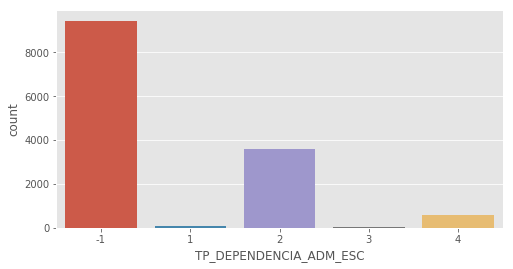

<Figure size 432x288 with 0 Axes>

In [75]:
df['TP_DEPENDENCIA_ADM_ESC'] = df['TP_DEPENDENCIA_ADM_ESC'].fillna(-1)
df['TP_DEPENDENCIA_ADM_ESC'] = df['TP_DEPENDENCIA_ADM_ESC'].astype('int')

ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_DEPENDENCIA_ADM_ESC', data=df)
plt.show()
plt.clf()

In [76]:
df.groupby('TP_DEPENDENCIA_ADM_ESC').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_DEPENDENCIA_ADM_ESC,,,,,,,,
-1,9448.0,332.617887,239.156887,0.0,0.000,414.50,498.625,935.1
1,64.0,554.862500,152.675558,0.0,471.100,570.45,647.750,818.6
2,3611.0,383.294988,186.838364,0.0,372.800,425.80,492.000,877.4
3,38.0,378.986842,213.491165,0.0,367.275,444.30,512.425,696.9
4,569.0,549.361687,177.008949,0.0,454.600,564.10,665.100,952.0


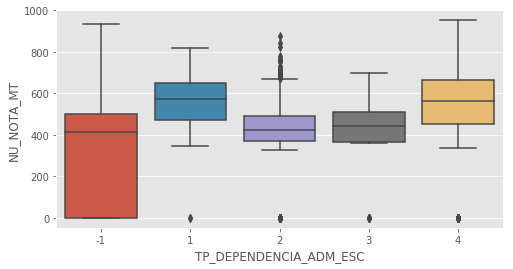

<Figure size 432x288 with 0 Axes>

In [77]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_DEPENDENCIA_ADM_ESC', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### IN_BAIXA_VISAO

Indicador de baixa visão, onde:

- `0`: Não
- `1`: Sim

Não há nulos.

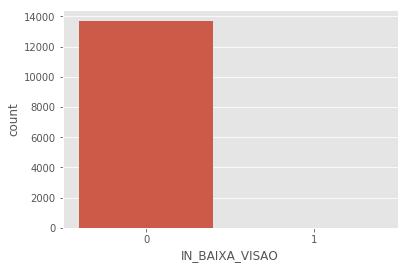

<Figure size 432x288 with 0 Axes>

In [78]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='IN_BAIXA_VISAO', data=df)
plt.show()
plt.clf()

In [79]:
df.groupby('IN_BAIXA_VISAO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
IN_BAIXA_VISAO,,,,,,,,
0,13713.0,356.145351,228.816160,0.0,0.0,422.6,504.4,952.0
1,17.0,313.547059,254.385898,0.0,0.0,405.2,445.2,699.9


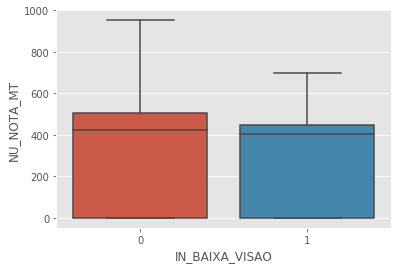

<Figure size 432x288 with 0 Axes>

In [80]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='IN_BAIXA_VISAO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### IN_SABATISTA

Indicador de solicitação de prova aplicada em horário diferenciado para os guardadores dos sábados, onde:

- `0`: Não
- `1`: Sim

Não há nulos.

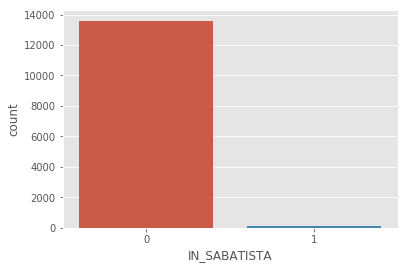

<Figure size 432x288 with 0 Axes>

In [81]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='IN_SABATISTA', data=df)
plt.show()
plt.clf()

In [82]:
df.groupby('IN_SABATISTA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
IN_SABATISTA,,,,,,,,
0,13597.0,356.148224,228.930958,0.0,0.0,422.5,504.5,952.0
1,133.0,350.406767,220.550385,0.0,0.0,421.7,502.2,710.0


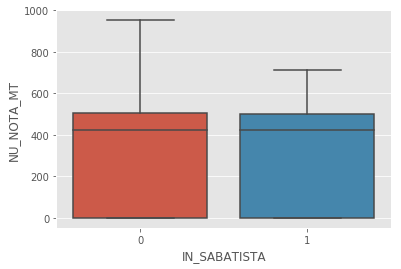

<Figure size 432x288 with 0 Axes>

In [83]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='IN_SABATISTA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_PRESENCA_CN

Presença na prova objetiva de Ciências da Natureza, onde:

- `0`: Faltou à prova
- `1`: Presente na prova
- `2`: Eliminado na prova

Não há nulos.

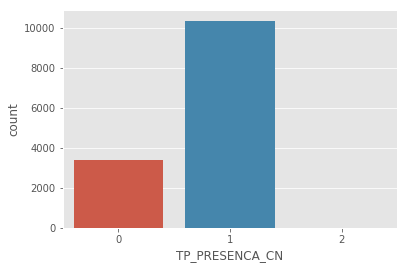

<Figure size 432x288 with 0 Axes>

In [84]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_PRESENCA_CN', data=df)
plt.show()
plt.clf()

In [85]:
df.groupby('TP_PRESENCA_CN').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_PRESENCA_CN,,,,,,,,
0,3380.0,4.311272,45.340663,0.0,0.0,0.0,0.0,878.3
1,10341.0,471.260352,122.760471,0.0,405.4,458.9,535.2,952.0
2,9.0,141.788889,213.248707,0.0,0.0,0.0,389.6,445.2


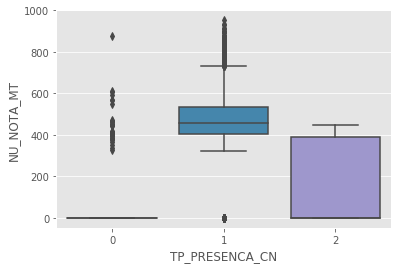

<Figure size 432x288 with 0 Axes>

In [86]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_PRESENCA_CN', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### TP_PRESENCA_CH

Presença na prova objetiva de Ciências Humanas, onde:

- `0`: Faltou à prova
- `1`: Presente na prova
- `2`: Eliminado na prova

Não há nulos.

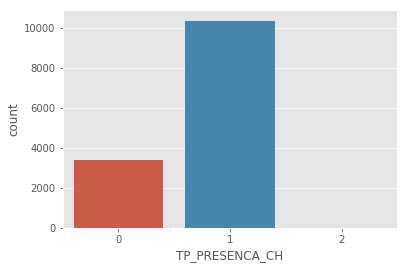

<Figure size 432x288 with 0 Axes>

In [87]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_PRESENCA_CH', data=df)
plt.show()
plt.clf()

In [88]:
df.groupby('TP_PRESENCA_CH').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_PRESENCA_CH,,,,,,,,
0,3380.0,4.311272,45.340663,0.0,0.0,0.0,0.0,878.3
1,10341.0,471.260352,122.760471,0.0,405.4,458.9,535.2,952.0
2,9.0,141.788889,213.248707,0.0,0.0,0.0,389.6,445.2


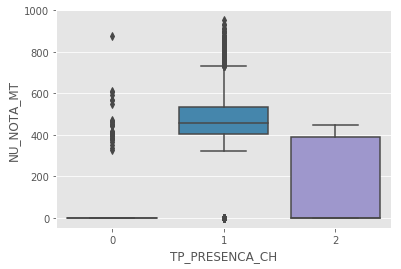

<Figure size 432x288 with 0 Axes>

In [89]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_PRESENCA_CH', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### CO_PROVA_MT

Código do tipo de prova de Matemática.

Não há valores nulos, mas as respostas estão representadas como strings alfanuméricos, então eu vou que trasformá-las em números.

Depois de feitos alguns gráficos vou trasformar essas variáveis em dummies, dropando a coluna `CO_PROVA_MT_0`.

In [90]:
le = LabelEncoder()

df['CO_PROVA_MT'] = le.fit_transform(df['CO_PROVA_MT'])

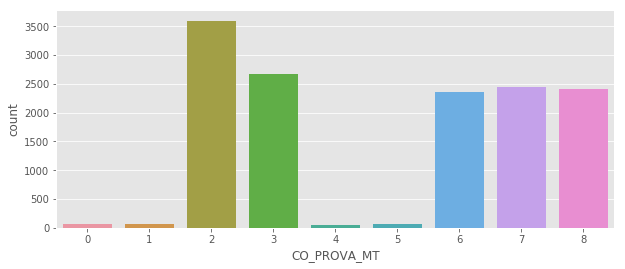

<Figure size 432x288 with 0 Axes>

In [91]:
ax, fig = plt.subplots(figsize=(10, 4))

sns.countplot(x='CO_PROVA_MT', data=df)
plt.show()
plt.clf()

In [92]:
df.groupby('CO_PROVA_MT').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
CO_PROVA_MT,,,,,,,,
0,67.0,494.676119,119.256093,344.6,399.000,478.40,570.550,826.1
1,64.0,457.146875,101.909811,320.5,384.500,424.05,514.325,805.1
2,3597.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
3,2664.0,477.770533,97.082116,0.0,406.200,457.70,527.825,916.6
4,54.0,477.229630,113.615496,328.0,396.500,445.55,538.200,757.2
5,63.0,485.358730,120.076501,327.6,394.250,446.80,558.450,803.6
6,2364.0,481.320601,102.229512,0.0,407.475,457.55,537.700,935.1
7,2454.0,491.035575,99.979587,0.0,415.725,470.20,548.275,952.0
8,2403.0,480.557179,98.234844,0.0,410.050,460.50,533.000,928.5


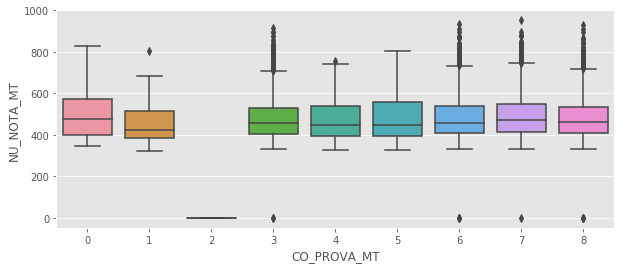

<Figure size 432x288 with 0 Axes>

In [93]:
ax, fig = plt.subplots(figsize=(10, 4))

sns.boxplot(x='CO_PROVA_MT', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

Transformando a variável em dummies:

In [94]:
dummies_CO_PROVA_MT = pd.get_dummies(df['CO_PROVA_MT'], prefix='CO_PROVA_MT')
dummies_CO_PROVA_MT.drop('CO_PROVA_MT_0', axis=1, inplace=True)

E juntando as novas variáveis dummy ao DataFrame original:

In [95]:
df.drop('CO_PROVA_MT', axis=1, inplace=True)
df = df.join(dummies_CO_PROVA_MT)

#### TP_STATUS_REDACAO

Situação da redação do participante, onde:

- `1`: Sem problemas
- `2`: Anulada
- `3`: Cópia Texto Motivador
- `4`: Em Branco
- `5`: Fere Direitos Humanos
- `6`: Fuga ao tema
- `7`: Não atendimento ao tipo
- `8`: Texto insuficiente
- `9`: Parte desconectada

Cerca de 1/4 das observações nessa variável são nulas. Vou manter esta variável e imputar os nulos com -1.

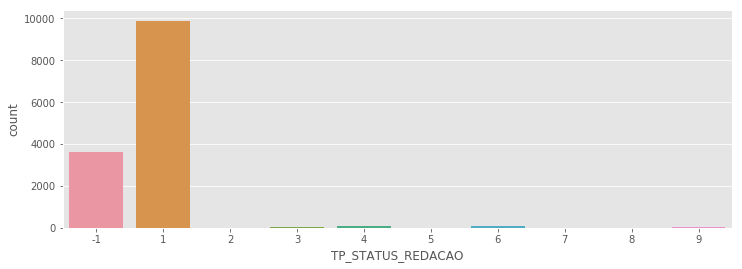

<Figure size 432x288 with 0 Axes>

In [96]:
df['TP_STATUS_REDACAO'] = df['TP_STATUS_REDACAO'].fillna(-1)
df['TP_STATUS_REDACAO'] = df['TP_STATUS_REDACAO'].astype('int')

ax, fig = plt.subplots(figsize=(12, 4))

sns.countplot(x='TP_STATUS_REDACAO', data=df)
plt.show()
plt.clf()

In [97]:
status_redacao_desc = df.groupby('TP_STATUS_REDACAO').describe()['NU_NOTA_MT'].sort_values('mean', ascending=False)
status_redacao_desc

,count,mean,std,min,25%,50%,75%,max
TP_STATUS_REDACAO,,,,,,,,
2,2.0,486.600000,45.113413,454.7,470.650,486.60,502.55,518.5
1,9892.0,483.508694,99.933968,0.0,409.475,461.90,539.10,952.0
9,20.0,461.955000,65.805595,364.8,417.875,438.35,484.00,618.0
8,8.0,458.987500,79.210776,391.6,409.350,444.30,461.65,642.1
4,96.0,447.909375,91.720040,0.0,394.150,435.15,482.20,812.0
6,85.0,432.150588,91.842169,0.0,383.500,422.30,468.20,896.3
3,16.0,425.431250,50.690416,359.9,388.550,417.40,452.25,531.6
7,6.0,425.366667,61.140319,339.4,388.450,423.25,477.10,494.4
5,8.0,413.512500,68.318110,355.4,367.550,399.00,423.60,567.9


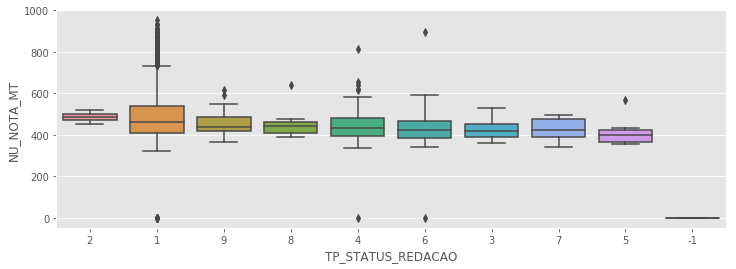

<Figure size 432x288 with 0 Axes>

In [98]:
ax, fig = plt.subplots(figsize=(12, 4))

sns.boxplot(x='TP_STATUS_REDACAO', y='NU_NOTA_MT', data=df, order=status_redacao_desc.index)
plt.show()
plt.clf()

#### NU_NOTA_COMPX

Nota de cada competência na prova de redação:

- *Competência 1*: Demonstrar domínio da modalidade escrita formal da Língua Portuguesa.
- *Competência 2*: Compreender a proposta de redação e aplicar conceitos das várias áreas de conhecimento para desenvolver o tema, dentro dos limites estruturais do texto dissertativo-argumentativo em prosa.
- *Competência 3*: Selecionar, relacionar, organizar e interpretar informações, fatos, opiniões e argumentos em defesa de um ponto de vista.
- *Competência 4*: Demonstrar conhecimento dos mecanismos linguísticos necessários para a construção da argumentação.
- *Competência 5*: Elaborar proposta de intervenção para o problema abordado, respeitando os direitos humanos.

Cerca de 1/4 das observações em cada uma dessas variáveis estão nulas e, pelo que podemos observar abaixo, na maioria dos casos, observações com nulos em uma dessas variáveis também terão nulos nas outras variáveis correspondentes.

In [99]:
NU_NOTA_COMPX = ['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
                 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

df[NU_NOTA_COMPX].head(n=20)

,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
0,120.0,120.0,120.0,80.0,80.0
1,140.0,120.0,120.0,120.0,80.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,120.0,120.0,120.0,160.0,100.0
6,100.0,120.0,120.0,120.0,100.0
7,140.0,120.0,120.0,120.0,120.0
8,140.0,160.0,140.0,140.0,100.0
9,NaN,NaN,NaN,NaN,NaN


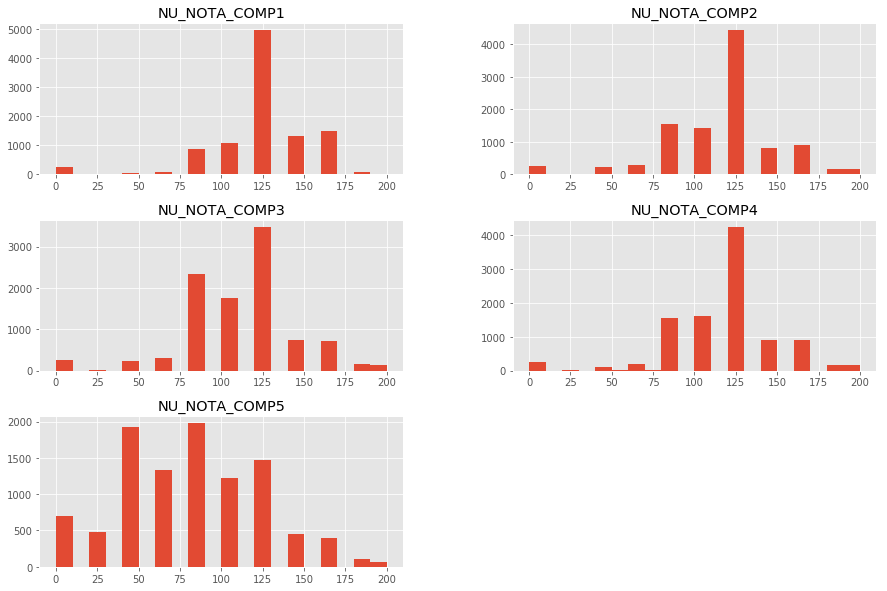

<Figure size 432x288 with 0 Axes>

In [100]:
df[NU_NOTA_COMPX].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

Eu não sei ao certo, mas eu suspeito que os nulos nessas variáveis correspondem aos indivíduos que não entregaram a prova. Sendo assim, eu imputarei nota zero aos nulos.

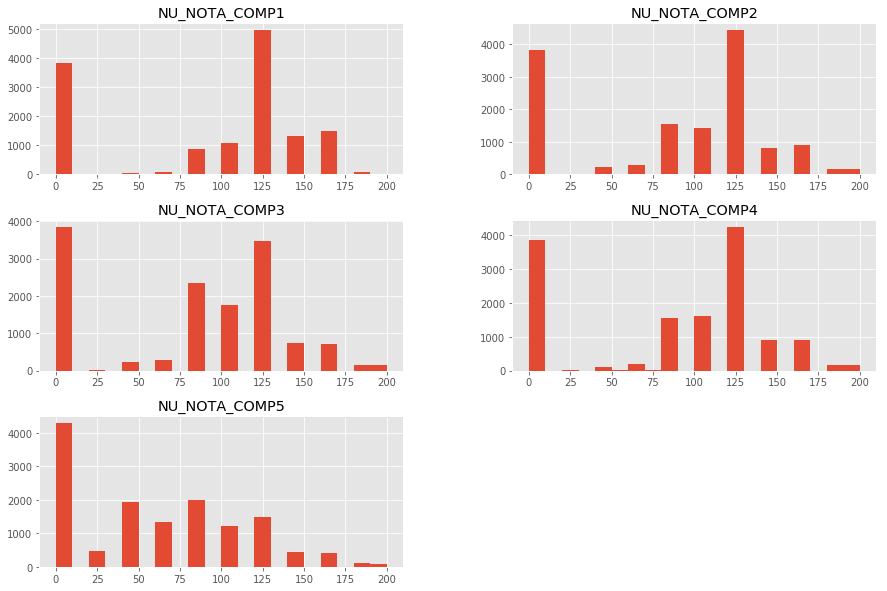

<Figure size 432x288 with 0 Axes>

In [101]:
df[NU_NOTA_COMPX] = df[NU_NOTA_COMPX].fillna(0.0)

df[NU_NOTA_COMPX].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

In [102]:
df[NU_NOTA_COMPX + ['NU_NOTA_MT']].head()

,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_MT
0,120.0,120.0,120.0,80.0,80.0,399.4
1,140.0,120.0,120.0,120.0,80.0,459.8
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
df[NU_NOTA_COMPX].describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_COMP1,13730.0,88.423307,58.592381,0.0,0.0,120.0,120.0,200.0
NU_NOTA_COMP2,13730.0,82.596067,57.112963,0.0,0.0,100.0,120.0,200.0
NU_NOTA_COMP3,13730.0,78.838310,55.469523,0.0,0.0,100.0,120.0,200.0
NU_NOTA_COMP4,13730.0,83.487618,57.460251,0.0,0.0,100.0,120.0,200.0
NU_NOTA_COMP5,13730.0,57.102331,50.263122,0.0,0.0,60.0,100.0,200.0


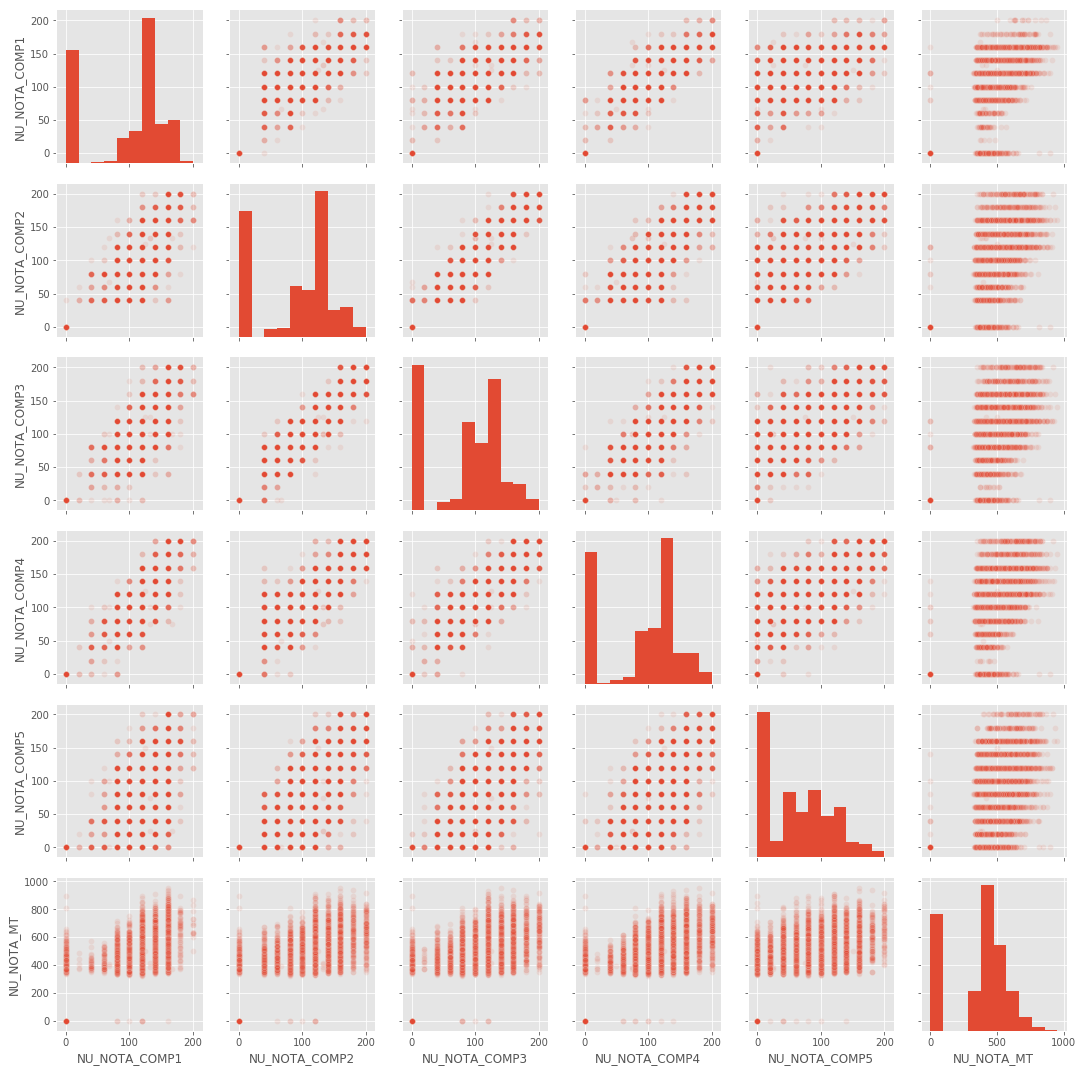

<Figure size 432x288 with 0 Axes>

In [104]:
sns.pairplot(df[NU_NOTA_COMPX + ['NU_NOTA_MT']], plot_kws={'alpha': 0.1, 'marker': 'o'})
plt.show()
plt.clf()

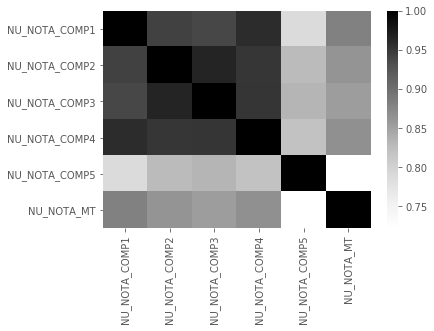

<Figure size 432x288 with 0 Axes>

In [105]:
corr_notas_comp = df[NU_NOTA_COMPX + ['NU_NOTA_MT']].corr()

sns.heatmap(corr_notas_comp, cmap='Greys')
plt.show()
plt.clf()

#### Q024 - Computador?

Corresponde à pergunta "Na sua residência tem computador?" do questionário socioeconômico, onde:

- `A`: Não
- `B`: Sim, um
- `C`: Sim, dois
- `D`: Sim, três
- `E`: Sim, quatro ou mais

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: Não
- `1`: Sim, um
- `2`: Sim, dois
- `3`: Sim, três
- `4`: Sim, quatro ou mais

In [106]:
le = LabelEncoder()

df['Q024'] = le.fit_transform(df['Q024'])

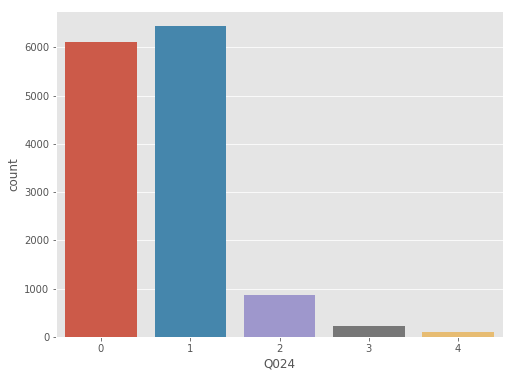

<Figure size 432x288 with 0 Axes>

In [107]:
ax, fig = plt.subplots(figsize=(8, 6))

sns.countplot(x='Q024', data=df)
plt.show()
plt.clf()

In [108]:
df.groupby('Q024').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q024,,,,,,,,
0,6107.0,322.436843,215.878786,0.0,0.000,405.20,468.30,862.5
1,6441.0,368.077503,231.128903,0.0,0.000,433.70,521.90,909.5
2,865.0,449.689942,238.703872,0.0,397.700,501.10,606.40,916.6
3,220.0,499.272727,238.080383,0.0,432.325,540.85,667.95,952.0
4,97.0,519.801031,254.518236,0.0,437.900,557.90,686.00,935.1


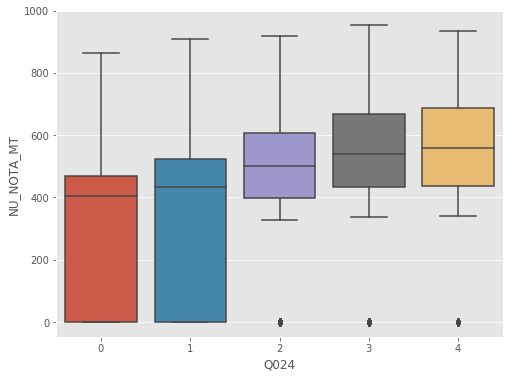

<Figure size 432x288 with 0 Axes>

In [109]:
ax, fig = plt.subplots(figsize=(8, 6))

sns.boxplot(x='Q024', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### Q025 - Internet?

Corresponde à pergunta "Na sua residência tem acesso à Internet?" do questionário socioeconômico, onde:

- `A`: Não
- `B`: Sim

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: Não
- `1`: Sim

In [110]:
le = LabelEncoder()

df['Q025'] = le.fit_transform(df['Q025'])

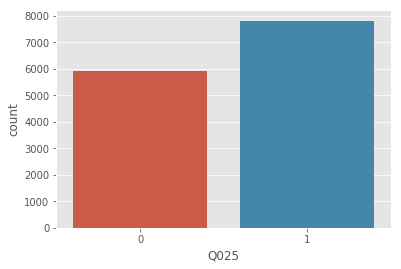

<Figure size 432x288 with 0 Axes>

In [111]:
sns.countplot(x='Q025', data=df)
plt.show()
plt.clf()

In [112]:
df.groupby('Q025').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q025,,,,,,,,
0,5915.0,325.548538,214.845060,0.0,0.00,406.5,469.55,896.3
1,7815.0,379.210736,236.297723,0.0,339.65,440.4,535.25,952.0


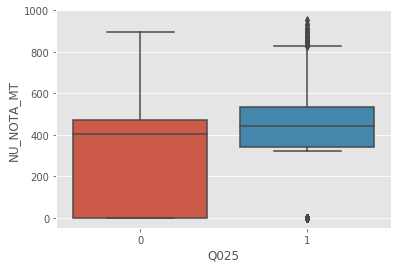

<Figure size 432x288 with 0 Axes>

In [113]:
sns.boxplot(x='Q025', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### Q027 - Idade começou a trabalhar

Corresponde à pergunta "Com que idade você começou a exercer uma atividade remunerada?" do questionário socioeconômico, onde:

- `A`: Menos de 14 anos
- `B`: 14 anos
- `C`: 15 anos
- ...
- `M`: 25 anos ou mais

Um pouco mais de 1/2 das respostas estão nulas, o que faz sentido, dado que na Q026 um pouco mais de metade dos indivíduos disse nunca ter trabalhado. Portanto, vou imputar os nulos com `N` e depois converter essas letras em números.

In [114]:
df['Q027'] = df['Q027'].fillna('N')

le = LabelEncoder()

df['Q027'] = le.fit_transform(df['Q027'])

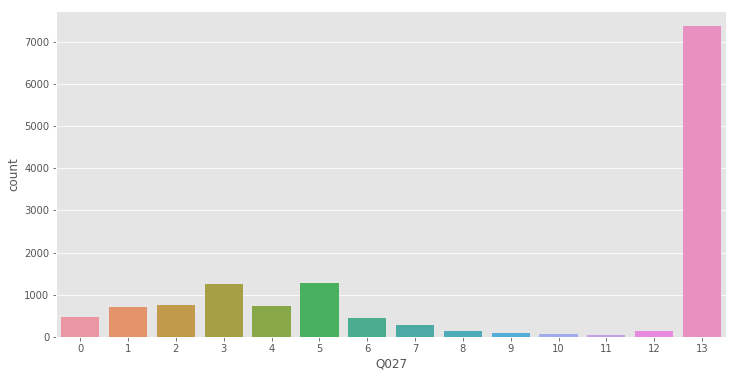

<Figure size 432x288 with 0 Axes>

In [115]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.countplot(x='Q027', data=df)
plt.show()
plt.clf()

In [116]:
df.groupby('Q027').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q027,,,,,,,,
0,475.0,271.803158,243.487104,0.0,0.0,380.60,476.200,771.1
1,699.0,303.729185,251.969595,0.0,0.0,404.80,504.050,851.0
2,751.0,321.470573,240.493810,0.0,0.0,412.30,494.850,874.1
3,1247.0,332.338172,241.741928,0.0,0.0,421.70,508.300,895.5
4,730.0,308.538904,243.132772,0.0,0.0,405.00,488.250,877.4
5,1267.0,293.285478,243.895348,0.0,0.0,399.30,486.700,878.3
6,435.0,289.306207,245.104969,0.0,0.0,395.20,478.100,800.1
7,275.0,279.408364,238.091042,0.0,0.0,391.60,459.800,790.7
8,141.0,304.870922,244.914466,0.0,0.0,395.30,474.900,848.3


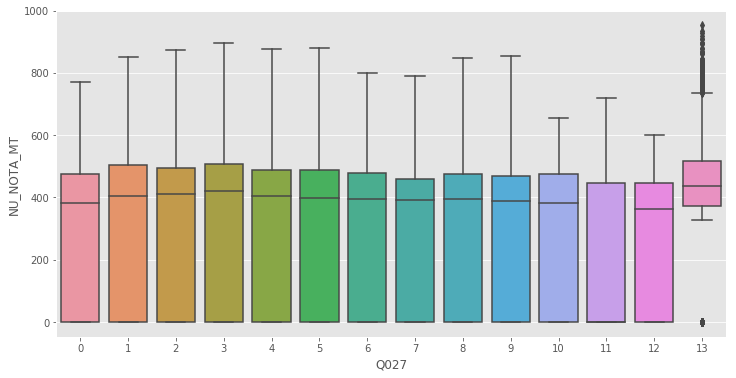

<Figure size 432x288 with 0 Axes>

In [117]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.boxplot(x='Q027', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

#### Q047 - Escola do EM

Corresponde à pergunta "Em que tipo de escola você frequentou o Ensino Médio?" do questionário socioeconômico, onde:

- `A`: Somente em escola pública
- `B`: Parte em escola pública e parte em escola privada sem bolsa de estudo integral.
- `C`: Parte em escola pública e parte em escola privada com bolsa de estudo integral.
- `D`: Somente em escola privada sem bolsa de estudo integral.
- `E`: Somente em escola privada com bolsa de estudo integral.

Não há valores nulos, mas as respostas estão representadas como letras, então depois de feitos alguns gráficos vou trasformá-las em dummies, dropando a última coluna, `Q047_E`.

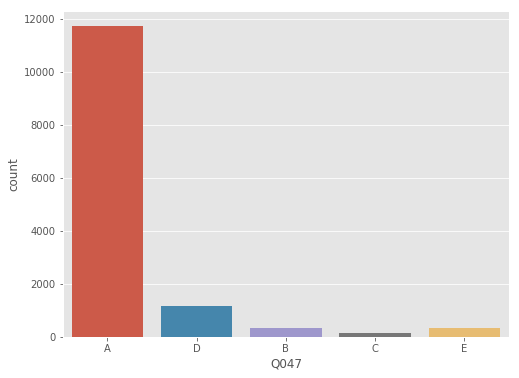

<Figure size 432x288 with 0 Axes>

In [118]:
ax, fig = plt.subplots(figsize=(8, 6))

sns.countplot(x='Q047', data=df)
plt.show()
plt.clf()

In [119]:
df.groupby('Q047').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q047,,,,,,,,
A,11726.0,337.160856,222.106337,0.0,0.00,414.05,487.075,916.6
B,348.0,361.149138,247.004564,0.0,0.00,433.90,537.200,807.8
C,162.0,381.777160,229.652813,0.0,349.35,445.65,527.675,765.2
D,1173.0,508.501620,223.038511,0.0,434.50,552.20,660.300,952.0
E,321.0,472.283801,228.519142,0.0,415.50,503.00,612.100,908.8


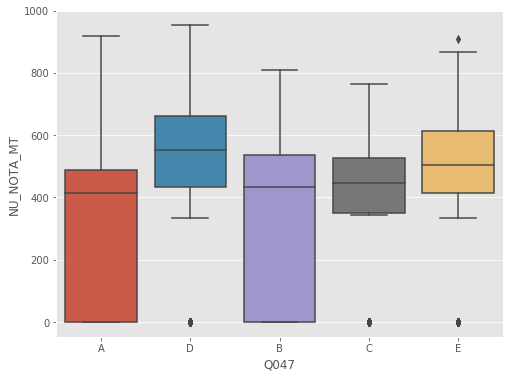

<Figure size 432x288 with 0 Axes>

In [120]:
ax, fig = plt.subplots(figsize=(8, 6))

sns.boxplot(x='Q047', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

Transformando as variáveis em dummies:

In [121]:
dummies_Q047 = pd.get_dummies(df['Q047'], prefix='Q047')
dummies_Q047.drop('Q047_E', axis=1, inplace=True)

E juntando as novas dummy features ao DataFrame original:

In [122]:
df.drop('Q047', axis=1, inplace=True)
df = df.join(dummies_Q047)

## Train test split

Antes de começar a criar nossos modelos, vamos separar nosso DataFrame em um de treino e um de teste.

In [123]:
X_df = df.drop('NU_NOTA_MT', axis=1)
y_df = df['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=0)

## Regressão linear - Baseline

Rodei aqui novamente o nosso mesmo modelo baseline (`_bl`), uma regressão linear muito simples, usando apenas as notas que o aluno obteve nas outras provas para prever sua nota na prova de matemática.

In [124]:
X_train_bl = X_train[['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']]
X_test_bl = X_test[['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']]

In [125]:
lr_bl = LinearRegression(fit_intercept=False)
lr_bl.fit(X_train_bl, y_train)
predictions_lr_bl = lr_bl.predict(X_test_bl)

Note o uso de `fit_intercept=False` acima. Faço isso para que alguns indivíduos não fiquem com notas negativas, e sim com nota `0`.

In [126]:
lr_bl.score(X_test_bl, y_test)

0.8996153050106224

## LGBM - Baseline

E novamente rodando o modelo LightGBM com as mesmas features da regressão linear acima para depois rodá-lo com um conjunto maior de features.

In [127]:
lgbm_bl = LGBMRegressor(random_state=0)
lgbm_bl.fit(X_train_bl, y_train)
predictions_lgbm_bl = lgbm_bl.predict(X_test_bl)

In [128]:
lgbm_bl.score(X_test_bl, y_test)

0.9175277807370835

## LGBM - Mais features

### LGBM inicial

Agora vamos usar todas as features que selecionamos e massageamos acima para treinar nosso modelo usando o LightGBM com seus hiperparâmetros padrão.

In [129]:
lgbm_sf = LGBMRegressor(random_state=0)
lgbm_sf.fit(X_train, y_train)
predictions_lgbm_sf = lgbm_sf.predict(X_test)

In [130]:
lgbm_sf.score(X_test, y_test)

0.9241278346223143

Vemos que, utilizando mais features aqui, conseguimos melhorar o R2 do modelo de cerca de 92.37% (no notebook anterior) para cerca de 92.41%.

### LGBM com random search

Para otimizar os hiperparâmetros do nosso modelo LGBM, começamos com um randomized search para termos uma ideia de onde estão os valores ideais.

Eu comentei as células abaixo pois o modelo demora um pouco para ser rodar. Incluí logo abaixo os resultados para os melhores hiperparâmetros (que vamos refinar com um grid search logo em seguida).

In [131]:
# rand_param_grid_lgbm = {
#     'learning_rate': stats.uniform(0.001, 0.4),
#     'n_estimators': [650],
#     'num_leaves': stats.randint(3, 50),
# }

In [132]:
# rand_search_cv = RandomizedSearchCV(lgbm_sf,
#                                     rand_param_grid_lgbm,
#                                     n_iter=100,
#                                     cv=3,
#                                     random_state=0,
#                                     verbose=2)

In [133]:
# rand_search_cv.fit(X_train, y_train, verbose=False)

In [134]:
# rand_search_cv.best_estimator_

```
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.009087358976130288, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=650, n_jobs=-1, num_leaves=8, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)
```

In [135]:
# rand_search_cv.best_params_

```
{'learning_rate': 0.009087358976130288, 'n_estimators': 650, 'num_leaves': 8}
```

In [136]:
# rand_search_cv.best_score_

```
0.92714975340295536
```

### LGBM com grid search

Agora, tendo uma melhor ideia de onde estão os valores ideais para os nossos hiperparâmetros, fazemos um grid search em torno dos valores que conseguimos com o random search.

In [137]:
# param_grid_lgbm = {
#     'learning_rate': np.linspace(0.009, 0.011, 20),
#     'n_estimators': [650],
#     'num_leaves': [4, 5, 6, 7, 8, 9, 10, 11],
# }

# Os valores abaixo são os melhores valores para os hiperparêmetros em questão
# quando usamos o grid de hipermarâmetros acima
param_grid_lgbm = {
    'learning_rate': [0.0099473684210526318],
    'n_estimators': [650],
    'num_leaves': [7],
    'random_state': [0]
}

In [138]:
grid_search_cv = GridSearchCV(lgbm_sf, param_grid_lgbm, cv=3, verbose=2)

In [139]:
grid_search_cv.fit(X_train, y_train, verbose=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0 
[CV]  learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0, total=   2.7s
[CV] learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0, total=   1.5s
[CV] learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0 
[CV]  learning_rate=0.009947368421052632, n_estimators=650, num_leaves=7, random_state=0, total=   1.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.009947368421052632], 'n_estimators': [650], 'num_leaves': [7], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [140]:
grid_search_cv.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.009947368421052632, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=650, n_jobs=-1, num_leaves=7, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [141]:
grid_search_cv.best_params_

{'learning_rate': 0.009947368421052632,
 'n_estimators': 650,
 'num_leaves': 7,
 'random_state': 0}

In [142]:
grid_search_cv.best_score_

0.9272221137060707

In [143]:
predictions_gscv = grid_search_cv.predict(X_test)

Com isso, conseguimos melhorar o R2 do modelo de cerca de 92.41% (usando os valores padrão para seus hiperparâmetros) para cerca de 92.72%.

## Explicando o modelo LGBM

### Permutation importance

*Permutation importance* é uma medida de quais features do nosso modelo têm o maior impacto sobre as previsões feitas.

Seu funcionamento é o seguinte:

- Depois que o modelo é treinado, os valores de uma única coluna do dataset são embaralhados (ou “permutados”) e o dataset resultante usado para fazer as previsões.
- Se essa feature for importante, a função de custo irá refletir isso, apresentando uma performance pior após sua permutação. Essa piora de performance mede a importância da feature permutada (quanto pior a performance da função de custo, mais importante é aquela feature).
- Repete-se isso para todas as colunas.

In [144]:
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

/anaconda3/envs/tera-env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [145]:
perm = PermutationImportance(grid_search_cv, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
1.4727 ± 0.0499,NU_NOTA_LC
0.0398 ± 0.0023,NU_NOTA_CN
0.0068 ± 0.0004,NU_NOTA_CH
0.0031 ± 0.0010,TP_SEXO
0.0014 ± 0.0003,Q006
0.0003 ± 0.0004,CO_PROVA_MT_7
0.0003 ± 0.0002,Q001
0.0002 ± 0.0004,NU_IDADE
0.0002 ± 0.0001,Q002
0.0002 ± 0.0001,Q047_A


Da tabela acima, vemos que a nota do indivíduo na prova de *Linguagens e Códigos* é de longe a feature com o maior impacto sobre o nosso modelo (seguida da nota nas outras provas objectivas do ENEM, como suspeitávamos quando fizemos a regressão linear que nos serviu de baseline). Também podemos ver o grande número de features que têm impacto ínfimo.

### Partial dependence plots

Se *permutation importance* (e outras técnicas para avaliar a importância de features) mostram **quais** features afetam previsões, *partial dependence plots* (PDPs) nos mostram **como** uma determinada feture afeta previsões.

Um PDP mostra o efeito marginal que uma feature tem sobre a variável target prevista: qual o formato da relação entre a feature e o target? É linear? Exponencial?

Assim como em *permutation importance*, PDPs são calculados após um modelo ser treinado.

In [146]:
# !pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

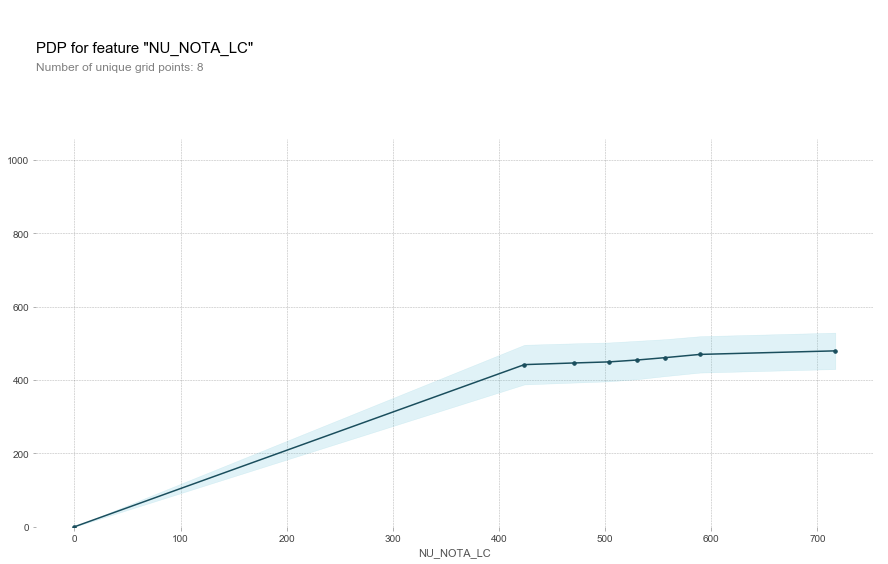

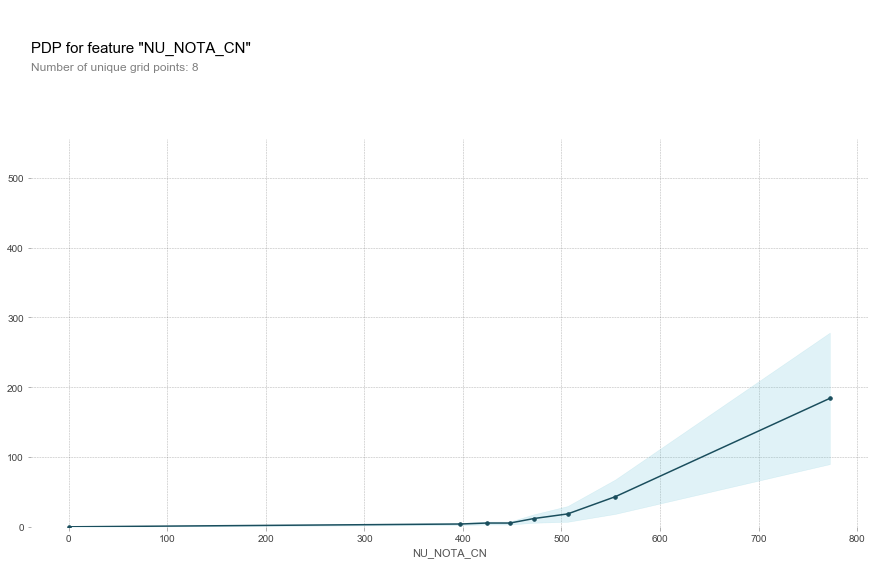

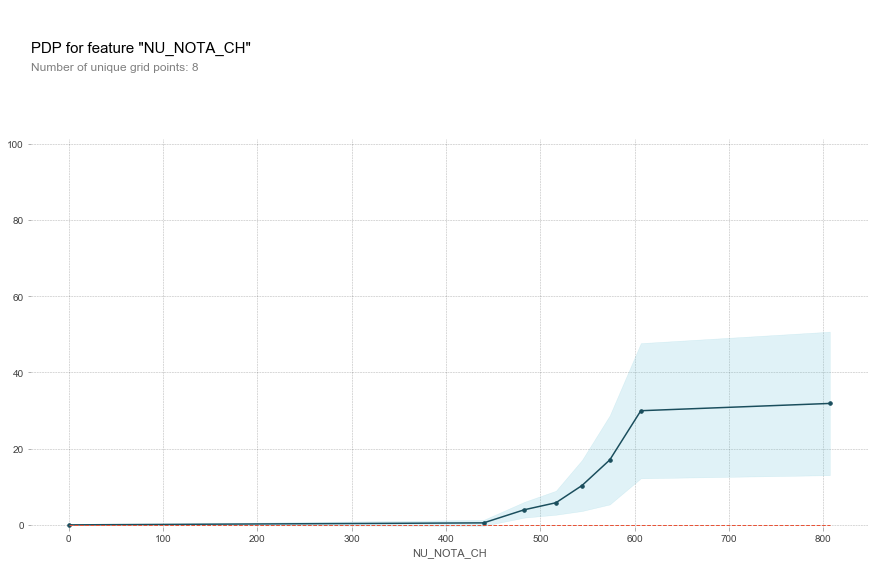

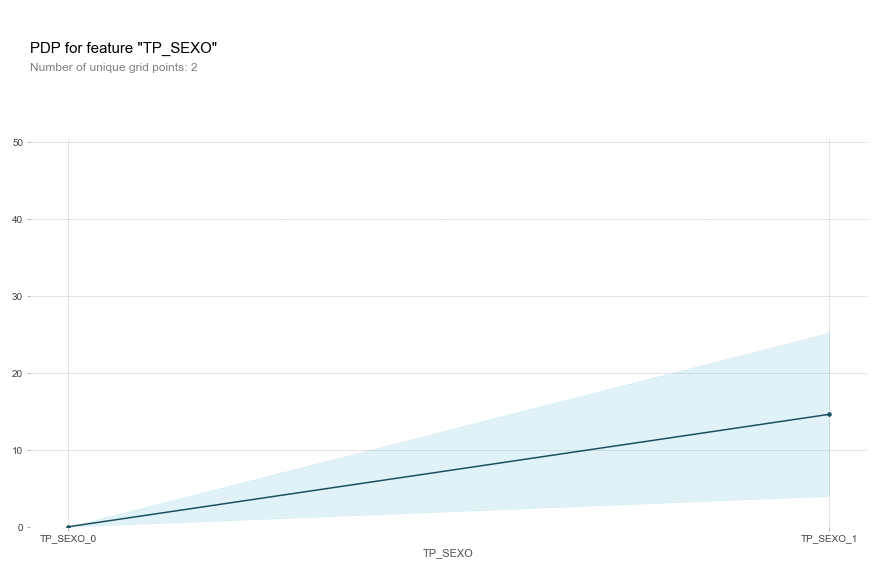

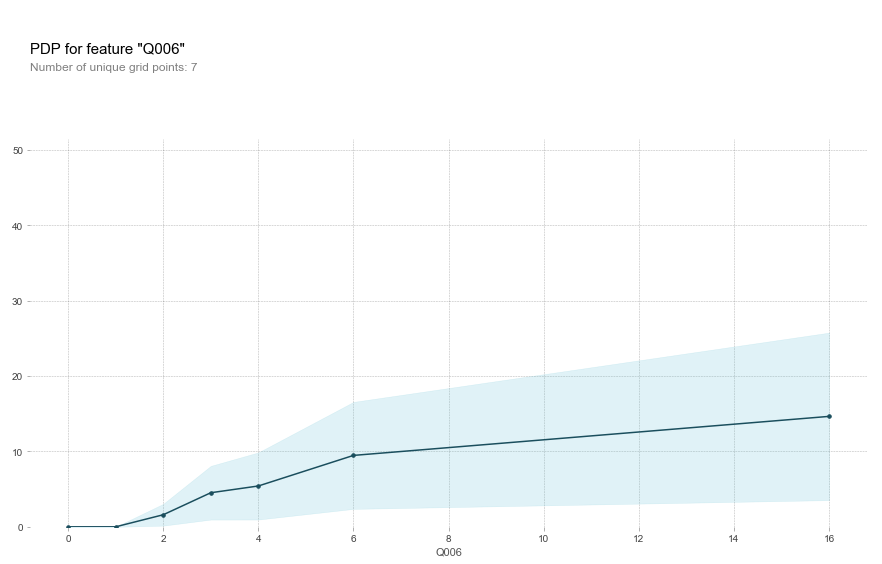

In [147]:
# Features selecionadas para os PDPs
selected_feats = ['NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'TP_SEXO', 'Q006']

for feat in selected_feats:
    pd_plot = pdp.pdp_isolate(model=grid_search_cv,
                              dataset=X_test,
                              model_features=X_test.columns.tolist(),
                              feature=feat)

    pdp.pdp_plot(pd_plot, feat)
    plt.show()

O eixo y de um PDP é interpretado como a diferença na previsão do que seria previsto no baseline (que é o valor mais à esquerda no eixo x).

A área colorida de azul indica o intervalo de confiança.

### SHAP values

SHAP values respondem por quê seu modelo fez uma determinada previsão para uma observação individual.

In [148]:
import shap

In [149]:
row_for_shap = 0  # Usamos 1 linha de dados aqui, mas poderíamos usar múltiplas linhas.

# Criando o objeto para calcular os SHAP values
explainer = shap.TreeExplainer(grid_search_cv.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values[row_for_shap, :],
                X_test.iloc[row_for_shap, :])

No nosso cálculo da *permutation importance* de cada feature, vimos que a `NU_NOTA_LC` é, de longe, a feature com o maior impacto sobre nossa previsão para o target, então não é de se espantar a importância que essa feature tem sobre uma observação individual.

#### SHAP summary plot:

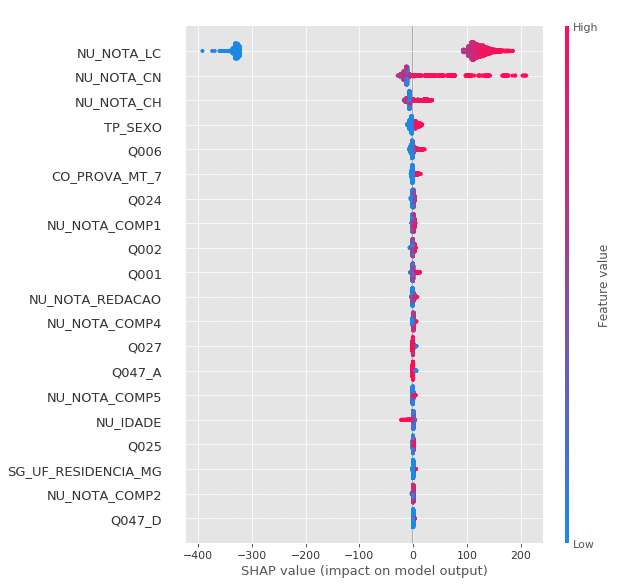

In [150]:
shap.summary_plot(shap_values, X_test)

#### SHAP dependence contribution plot

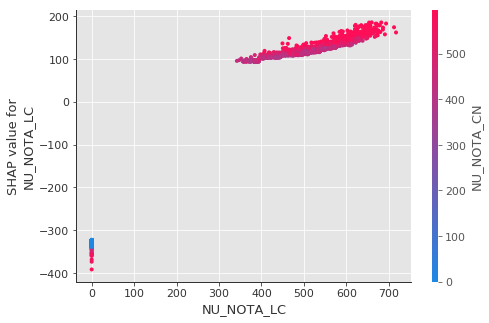

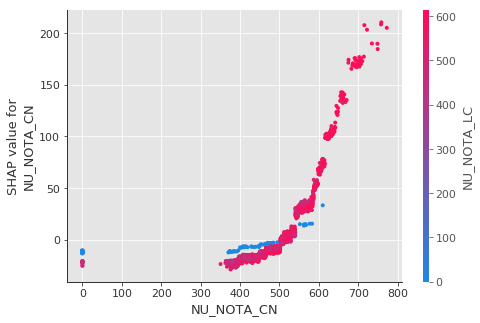

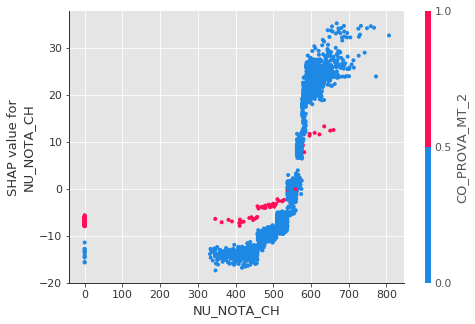

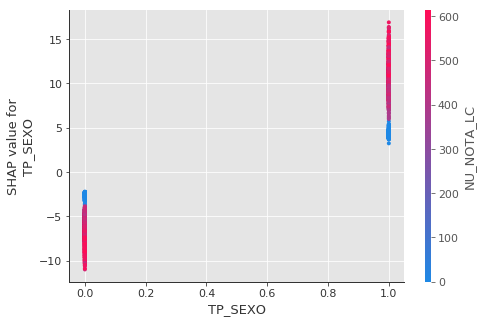

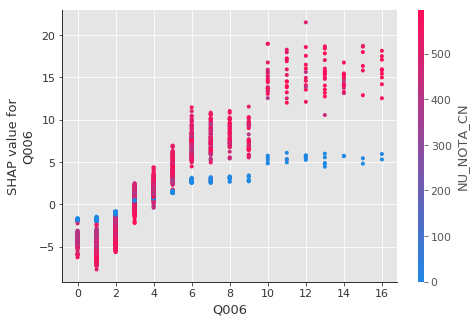

In [151]:
for feat in selected_feats:
    shap.dependence_plot(feat, shap_values, X_test)

## Resposta do desafio

O desafio disponibiliza um arquivo `test.csv` para validar nosso modelo e ranquear os participantes na competição.

In [152]:
data_resposta = pd.read_csv('test.csv', header=0)

Criando um DataFrame do arquivo de testes apenas com as features que eu usei no meu modelo:

In [153]:
feat_cols_resposta = (feat_cols + additional_feat_cols).copy()
feat_cols_resposta.remove('NU_NOTA_MT')

df_resposta = data_resposta[feat_cols_resposta]

df_resposta.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,...,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,Q024,Q025,Q027,Q047
0,22,F,3,1,1,5,1,NaN,0,464.8,...,1.0,120.0,80.0,80.0,100.0,40.0,A,A,C,A
1,26,F,3,1,1,8,1,NaN,0,391.1,...,1.0,120.0,120.0,120.0,120.0,100.0,B,B,F,A
2,21,M,1,1,2,0,2,3.0,0,595.9,...,1.0,80.0,40.0,40.0,80.0,80.0,B,B,NaN,A
3,27,F,3,1,1,8,1,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,A
4,18,M,1,1,2,0,2,1.0,0,592.9,...,1.0,100.0,80.0,60.0,80.0,0.0,C,B,NaN,A


Agora precisamos tratar os dados do arquivo de teste da mesma maneira que tratamos os dados do arquivo de treino, que foi basicamente tratar os nulos, converter variáveis categóricas para números e converter dtypes:

In [154]:
# TP_ENSINO
df_resposta['TP_ENSINO'] = df_resposta['TP_ENSINO'].fillna(-1)
df_resposta['TP_ENSINO'] = df_resposta['TP_ENSINO'].astype('int')

# NU_NOTA_X
NU_NOTA_X_resposta = ['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']
df_resposta[NU_NOTA_X_resposta] = df_resposta[NU_NOTA_X_resposta].fillna(0.0)

# Q026
le = LabelEncoder()
df_resposta['Q026'] = le.fit_transform(df_resposta['Q026'])

# TP_SEXO
le = LabelEncoder()
df_resposta['TP_SEXO'] = le.fit_transform(df_resposta['TP_SEXO'])

# TP_COR_RACA
dummies_TP_COR_RACA_resposta = pd.get_dummies(df_resposta['TP_COR_RACA'], prefix='TP_COR_RACA')
dummies_TP_COR_RACA_resposta.drop('TP_COR_RACA_5', axis=1, inplace=True)
df_resposta.drop('TP_COR_RACA', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_TP_COR_RACA_resposta)

# TP_NACIONALIDADE
dummies_TP_NACIONALIDADE_resposta = pd.get_dummies(df_resposta['TP_NACIONALIDADE'], prefix='TP_NACIONALIDADE')
dummies_TP_NACIONALIDADE_resposta.drop('TP_NACIONALIDADE_0', axis=1, inplace=True)
df_resposta.drop('TP_NACIONALIDADE', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_TP_NACIONALIDADE_resposta)

# TP_ESCOLA
dummies_TP_ESCOLA_resposta = pd.get_dummies(df_resposta['TP_ESCOLA'], prefix='TP_ESCOLA')
#dummies_TP_ESCOLA_resposta.drop('TP_ESCOLA_4', axis=1, inplace=True) # Linha comentada porque não há nenhum indivíduo com TP_ESCOLA == 4 no dataset de validação
df_resposta.drop('TP_ESCOLA', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_TP_ESCOLA_resposta)

# Q006
le = LabelEncoder()
df_resposta['Q006'] = le.fit_transform(df_resposta['Q006'])

# Q001
le = LabelEncoder()
df_resposta['Q001'] = le.fit_transform(df_resposta['Q001'])
df_resposta['Q001'] = df_resposta['Q001'].apply(lambda x: -1 if x == 7 else x)

# Q002
le = LabelEncoder()
df_resposta['Q002'] = le.fit_transform(df_resposta['Q002'])
df_resposta['Q002'] = df_resposta['Q002'].apply(lambda x: -1 if x == 7 else x)

# ----------

# SG_UF_RESIDENCIA
# le = LabelEncoder()
# df_resposta['SG_UF_RESIDENCIA'] = le.fit_transform(df_resposta['SG_UF_RESIDENCIA'])
dummies_SG_UF_RESIDENCIA_resposta = pd.get_dummies(df_resposta['SG_UF_RESIDENCIA'], prefix='SG_UF_RESIDENCIA')
dummies_SG_UF_RESIDENCIA_resposta.drop('SG_UF_RESIDENCIA_AC', axis=1, inplace=True)
df_resposta.drop('SG_UF_RESIDENCIA', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_SG_UF_RESIDENCIA_resposta)

# TP_DEPENDENCIA_ADM_ESC
df_resposta['TP_DEPENDENCIA_ADM_ESC'] = df_resposta['TP_DEPENDENCIA_ADM_ESC'].fillna(-1)
df_resposta['TP_DEPENDENCIA_ADM_ESC'] = df_resposta['TP_DEPENDENCIA_ADM_ESC'].astype('int')

# CO_PROVA_MT
le = LabelEncoder()
df_resposta['CO_PROVA_MT'] = le.fit_transform(df_resposta['CO_PROVA_MT'])
dummies_CO_PROVA_MT_resposta = pd.get_dummies(df_resposta['CO_PROVA_MT'], prefix='CO_PROVA_MT')
dummies_CO_PROVA_MT_resposta.drop('CO_PROVA_MT_0', axis=1, inplace=True)
df_resposta.drop('CO_PROVA_MT', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_CO_PROVA_MT_resposta)

# TP_STATUS_REDACAO
df_resposta['TP_STATUS_REDACAO'] = df_resposta['TP_STATUS_REDACAO'].fillna(-1)
df_resposta['TP_STATUS_REDACAO'] = df_resposta['TP_STATUS_REDACAO'].astype('int')

# NU_NOTA_COMPX
df_resposta[NU_NOTA_COMPX] = df_resposta[NU_NOTA_COMPX].fillna(0.0)

# Q024
le = LabelEncoder()
df_resposta['Q024'] = le.fit_transform(df_resposta['Q024'])

# Q025
le = LabelEncoder()
df_resposta['Q025'] = le.fit_transform(df_resposta['Q025'])

# Q027
df_resposta['Q027'] = df_resposta['Q027'].fillna('N')
le = LabelEncoder()
df_resposta['Q027'] = le.fit_transform(df_resposta['Q027'])

# Q047
dummies_Q047_resposta = pd.get_dummies(df_resposta['Q047'], prefix='Q047')
dummies_Q047_resposta.drop('Q047_E', axis=1, inplace=True)
df_resposta.drop('Q047', axis=1, inplace=True)
df_resposta = df_resposta.join(dummies_Q047_resposta)

df_resposta.head()

,NU_IDADE,TP_SEXO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,...,CO_PROVA_MT_3,CO_PROVA_MT_4,CO_PROVA_MT_5,CO_PROVA_MT_6,CO_PROVA_MT_7,CO_PROVA_MT_8,Q047_A,Q047_B,Q047_C,Q047_D
0,22,0,1,5,-1,0,464.8,443.5,431.8,0,...,0,0,0,0,1,0,1,0,0,0
1,26,0,1,8,-1,0,391.1,491.1,548.0,1,...,1,0,0,0,0,0,1,0,0,0
2,21,1,2,0,3,0,595.9,622.7,613.6,0,...,0,0,0,0,0,1,1,0,0,0
3,27,0,1,8,-1,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,18,1,2,0,1,0,592.9,492.6,571.4,1,...,0,0,0,1,0,0,1,0,0,0


E, finalmente, gerando nossas respostas para o arquivo de teste:

In [155]:
# Predict answers to test.csv based on LightGBM model with grid search
predictions_resposta = grid_search_cv.predict(df_resposta)

Ajustando para exatamente zero as notas previstas pelo nosso modelo como negativas ou muito baixas.

In [156]:
predictions_resposta = [0 if i<20 else i for i in predictions_resposta]

E gerando o arquivo de resposta:

In [157]:
nu_inscricao = data_resposta[['NU_INSCRICAO']]
nu_nota_mt = pd.DataFrame(predictions_resposta, index=data_resposta.index, columns=['NU_NOTA_MT'])

answer = nu_inscricao.join(nu_nota_mt)
answer.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,432.251560
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,440.012027
2,b38a03232f43b11c9d0788abaf060f7366053b6d,587.407919
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,557.434594


In [158]:
answer.to_csv('answer.csv', index=False)